#Carlos Alfredo Percca Anchapuri
GITHUB : https://github.com/CarlosPercca/ESIS-IA-LAB4B.git
# 4b. Despliegue de su modelo
Ahora que tenemos un modelo bien entrenado, es hora de utilizarlo. En este ejercicio, expondremos nuevas im√°genes a nuestro modelo y detectaremos las letras correctas del alfabeto del lenguaje de signos. ¬°Vamos a empezar!

## 4b.1 Objetivos

* Cargar desde disco un modelo ya entrenado
* Reformatear im√°genes para un modelo entrenado con im√°genes de formato diferente.
* Realizar inferencias con im√°genes nuevas, nunca vistas por el modelo entrenado y evaluar su rendimiento.

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.io as tv_io
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 4b.2 Cargando el Modelo

Ahora que estamos en un nuevo cuaderno, vamos a cargar el modelo guardado que hemos entrenado. Nuestro guardado del ejercicio anterior cre√≥ una carpeta llamada ¬´asl_model¬ª. Podemos cargar el modelo seleccionando la misma carpeta.

Dado que nuestro modelo utiliza un [m√≥dulo personalizado](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html), necesitaremos cargar el c√≥digo de esa clase. Hemos guardado una copia del c√≥digo en [utils.py](./uitls.py).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install -y p7zip-full
!wget https://github.com/CarlosPercca/ESIS-IA-LAB4B/raw/main/MNIST.7z -O MNIST.7Z
!7z x MNIST.7Z
!rm -f MNIST.7Z

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
--2025-05-01 00:15:33--  https://github.com/CarlosPercca/ESIS-IA-LAB4B/raw/main/MNIST.7z
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CarlosPercca/ESIS-IA-LAB4B/main/MNIST.7z [following]
--2025-05-01 00:15:34--  https://raw.githubusercontent.com/CarlosPercca/ESIS-IA-LAB4B/main/MNIST.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1679852 (1.6M) [application/octet-stream]
Savi

In [ ]:
from utils import MyConvBlock

Ahora que tenemos una definici√≥n para `MyConvBlock`, podemos usar [torch.load](https://pytorch.org/docs/stable/generated/torch.load.html) para cargar un modelo desde una ruta. Podemos usar `map_location` para especificar el dispositivo. Cuando imprimimos el modelo, ¬øse ve igual que en el √∫ltimo cuaderno?

In [ ]:
model = torch.load('model.pth', map_location=device, weights_only=False)
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=675, out_features=512, bias=True)
    (15): Dropout

Tambi√©n podemos verificar si el modelo est√° en nuestra GPU.

In [ ]:
next(model.parameters()).device

device(type='cuda', index=0)

## 4b.3 Preparar una imagen para el modelo

Ahora es el momento de utilizar el modelo para hacer predicciones sobre nuevas im√°genes que nunca ha visto antes. Esto tambi√©n se llama inferencia. Tenemos un conjunto de im√°genes en la carpeta `data/asl_images`. Intenta abrirla utilizando el navegador de la izquierda y explora las im√°genes.

Te dar√°s cuenta de que las im√°genes que tenemos son de mucha mayor resoluci√≥n que las im√°genes de nuestro conjunto de datos. Tambi√©n son en color. Recuerda que nuestras im√°genes en el conjunto de datos eran de 28x28 p√≠xeles y en escala de grises. Es importante tener en cuenta que siempre que hacemos predicciones con un modelo, la entrada debe coincidir con la forma de los datos con los que se entren√≥ el modelo. Para este modelo, el conjunto de datos de entrenamiento ten√≠a la forma: (27455, 28, 28, 1). Esto correspond√≠a a 27455 im√°genes de 28 por 28 p√≠xeles cada una con un canal de color (escala de grises).

### 4b.3.1 Mostrar las im√°genes

Cuando utilicemos nuestro modelo para hacer predicciones sobre nuevas im√°genes, ser√° √∫til mostrar tambi√©n la imagen. Para ello, podemos utilizar la biblioteca matplotlib.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

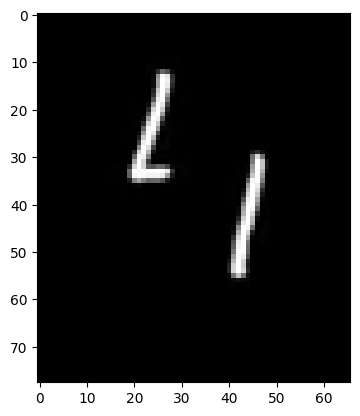

In [ ]:
show_image('/content/test/blot/4.png')

### 4b.3.2 Escalado de las im√°genes

Las im√°genes de nuestro conjunto de datos eran de 28x28 p√≠xeles y en escala de grises. Necesitamos asegurarnos de pasar el mismo tama√±o e im√°genes en escala de grises a nuestro m√©todo para la predicci√≥n. Hay algunas formas de editar im√°genes con Python, pero TorchVision tambi√©n tiene la funci√≥n [read_image](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html). Podemos hacerle saber qu√© tipo de imagen leer con [ImageReadMode](https://pytorch.org/vision/stable/generated/torchvision.io.ImageReadMode.html#torchvision.io.ImageReadMode).

In [ ]:
image = tv_io.read_image('/content/test/blot/1.png', tv_io.ImageReadMode.GRAY)
image

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

Fij√©monos en la forma de la imagen.

In [ ]:
image.shape

torch.Size([1, 78, 80])

Esta imagen es mucho m√°s grande que con la que entrenamos. Podemos utilizar [TorchVision](https://pytorch.org/vision/stable/index.html)'s [Transforms](https://pytorch.org/vision/0.9/transforms.html) de nuevo para obtener los datos en la forma que nuestro modelo espera.

Lo haremos:
* Convertiremos la imagen a float con [ToDtype](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ToDtype.html)
  * Estableceremos `scale` a `True` para convertir de [0, 255] a [0, 1].
* [Redimensionar](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Resize.html#torchvision.transforms.v2.Resize) la imagen para que sea de 28 x 28 p√≠xeles
* Convertir las im√°genes a [Escala de grises](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Grayscale.html#torchvision.transforms.v2.Grayscale)
  * Este paso no hace nada ya que nuestros modelos ya est√°n en escala de grises, pero lo hemos a√±adido aqu√≠ para mostrar una forma alternativa de obtener im√°genes en escala de grises.

In [ ]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Grayscale()  # From Color to Gray
])

Probemos `preprocess_trans` en una imagen para asegurarnos de que funciona correctamente:

In [ ]:
processed_image = preprocess_trans(image)
processed_image

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+

Los n√∫meros parecen correctos, pero ¬øy la forma?

In [ ]:
processed_image.shape

torch.Size([1, 28, 28])

A continuaci√≥n, vamos a trazar la imagen para ver si se parece a lo que hemos entrenado.

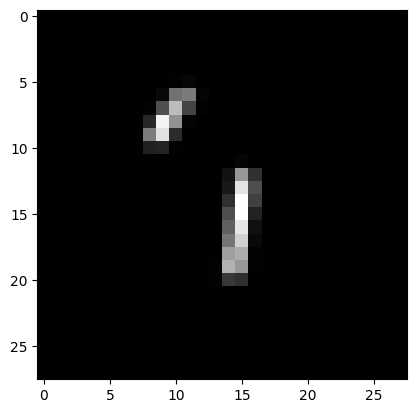

In [ ]:
plot_image = F.to_pil_image(processed_image)
plt.imshow(plot_image, cmap='gray')

¬°Se ve bien! Pas√©moslo a nuestro modelo.

### 4b.4 Hacer predicciones

Bien, ¬°ahora estamos listos para predecir! Nuestro modelo sigue esperando un lote de im√°genes. Si [squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.htmlhttps://pytorch.org/docs/stable/generated/torch.squeeze.html) elimina dimensiones de 1, [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.htmlhttps://pytorch.org/docs/stable/generated/torch.unsqueeze.html) a√±ade una dimensi√≥n de 1 en el √≠ndice que especifiquemos. La primera dimensi√≥n suele ser la dimensi√≥n del lote, por lo que podemos decir `.unsqueeze(0)`.

In [ ]:
batched_image = processed_image.unsqueeze(0)
batched_image.shape

torch.Size([1, 1, 28, 28])

A continuaci√≥n, debemos asegurarnos de que el tensor de entrada est√° en el mismo `dispositivo` que el modelo.

In [ ]:
batched_image_gpu = batched_image.to(device)
batched_image_gpu.device

device(type='cuda', index=0)

Ahora estamos listos para pasarlo al modelo.

In [ ]:
output = model(batched_image_gpu)
output

W0501 00:15:47.262000 332 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


tensor([[-4.5479,  3.0743, -1.5347, -5.3671, -7.6566, -2.9609, -3.4663, -2.2378,
         -6.2555, -6.2517]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)

### 4b.4.1 Comprender la predicci√≥n

Las predicciones tienen el formato de una matriz de 10
 longitudes. Cuanto mayor sea el valor, m√°s probable es que la imagen de entrada pertenezca a la clase correspondiente. Hag√°moslo un poco m√°s legible. Podemos empezar por encontrar qu√© elemento de la matriz representa la mayor probabilidad. Esto puede hacerse f√°cilmente con la biblioteca numpy y la funci√≥n [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

In [ ]:
prediction = output.argmax(dim=1).item()
prediction

1

In [ ]:
alphabet = "0123456789"

Ahora podemos pasar nuestro √≠ndice de predicci√≥n para encontrar la letra correspondiente.

In [ ]:
alphabet[prediction]

'1'

#### Ejercicio: P√≥ngalo todo junto

In [ ]:
def plot_probabilities(logits, alphabet="0123456789"):

    if isinstance(logits, torch.Tensor):
        logits = logits.squeeze().detach().cpu()

    probs = torch.nn.functional.softmax(logits, dim=0).numpy()

    df = pd.DataFrame({'Clase': list(alphabet), 'Probabilidad': probs})

    plt.figure(figsize=(10, 5))

    sns.barplot(data=df, x="Clase", y="Probabilidad", hue="Clase", palette="viridis", legend=False)

    max_idx = np.argmax(probs)
    plt.title(f"Distribuci√≥n de probabilidad - Predicci√≥n: {alphabet[max_idx]}")
    plt.xlabel("Clases")
    plt.ylabel("Probabilidad")
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


Pongamos todo en una funci√≥n para que podamos hacer predicciones s√≥lo a partir del archivo de imagen. Implem√©ntalo en la funci√≥n de abajo usando las funciones y pasos anteriores. Si necesitas ayuda, puedes revelar la soluci√≥n haciendo clic en los tres puntos de abajo.

In [ ]:
def predict_letter(file_path):
    # Show image
    show_image(file_path)
    # Load and grayscale image
    image = tv_io.read_image(file_path, tv_io.ImageReadMode.GRAY)
    #image = 255 - image
    # Transform image
    image = preprocess_trans(image)
    # Batch image
    image = image.unsqueeze(0)
    # Send image to correct device
    image = image.to(device)
    # Make prediction
    output = model(image)

    plot_probabilities(output)

    # Find max index
    prediction = output.argmax(dim=1).item()
    # Convert prediction to letter
    predicted_letter = alphabet[prediction]
    # Return prediction
    return predicted_letter

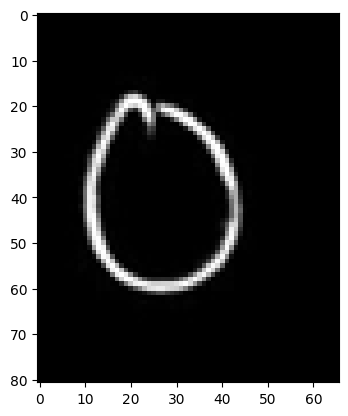

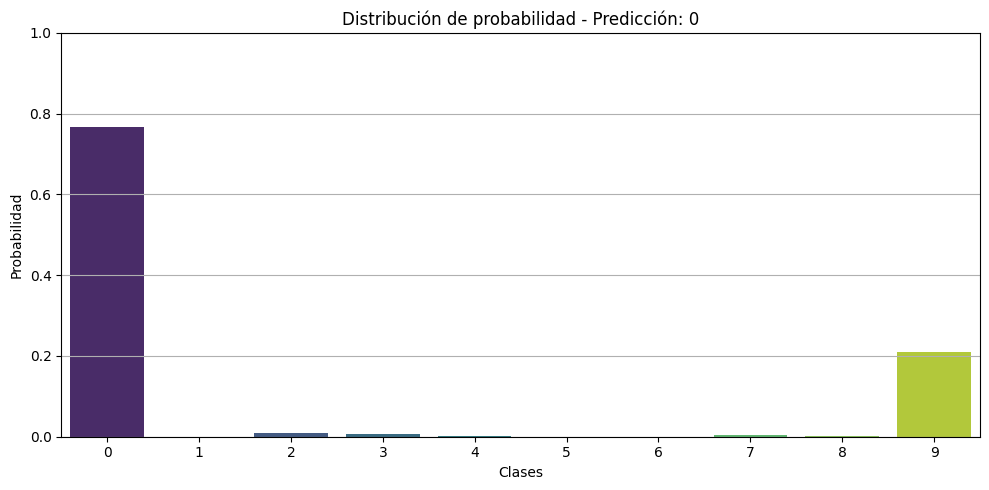

'0'

In [ ]:
predict_letter('/content/test/number/0.png')


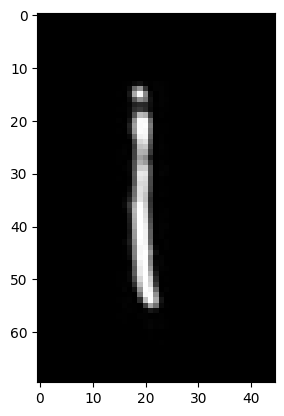

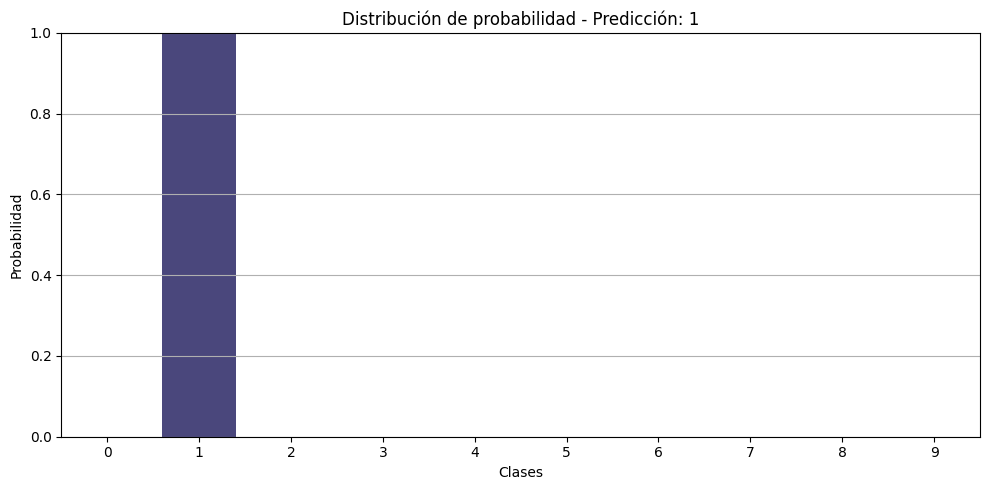

'1'

In [ ]:
predict_letter('/content/test/number/1.png')

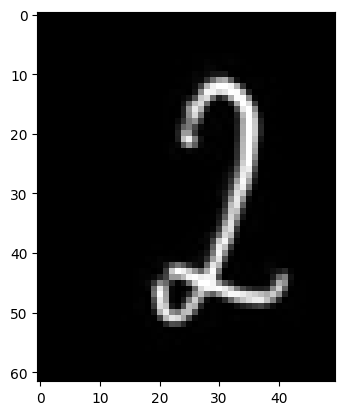

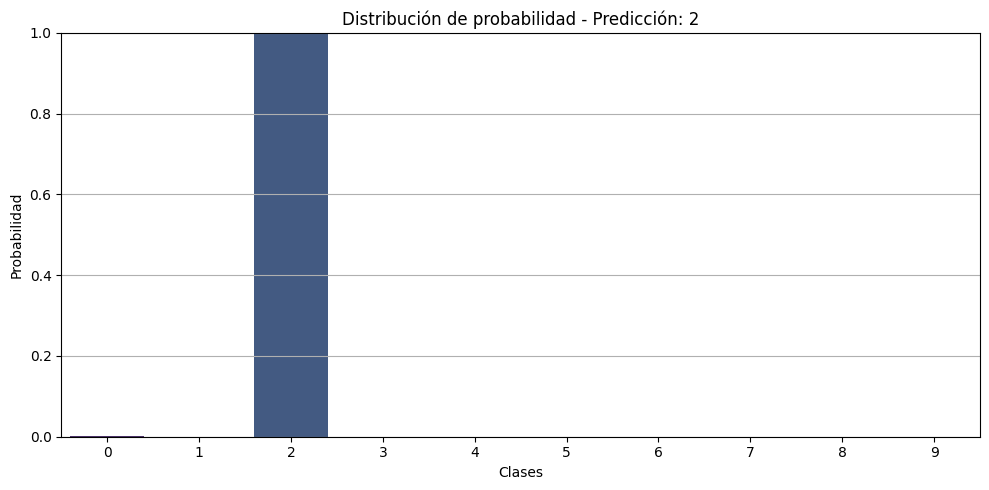

'2'

In [ ]:
predict_letter('/content/test/number/2.png')

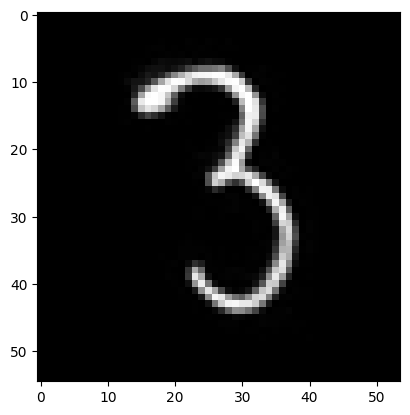

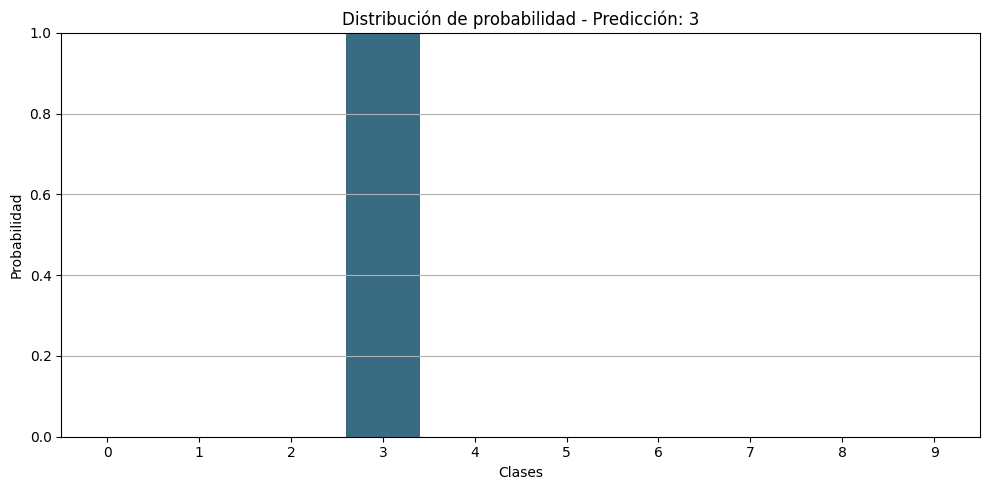

'3'

In [ ]:
predict_letter('/content/test/number/3.png')

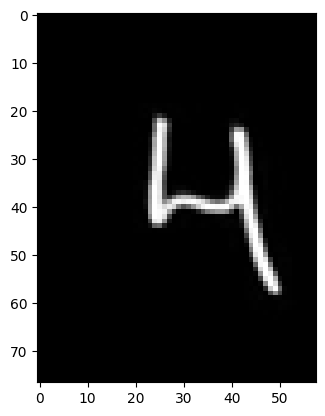

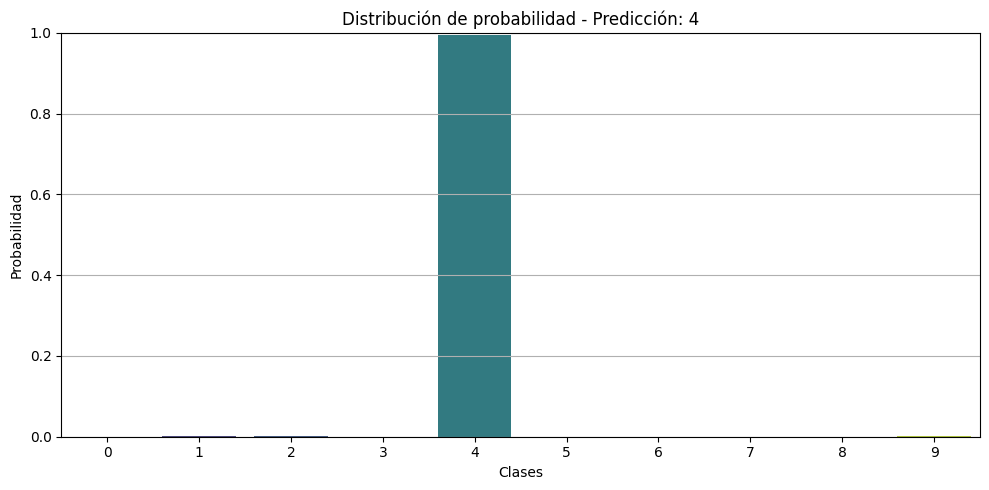

'4'

In [ ]:
predict_letter('/content/test/number/4.png')

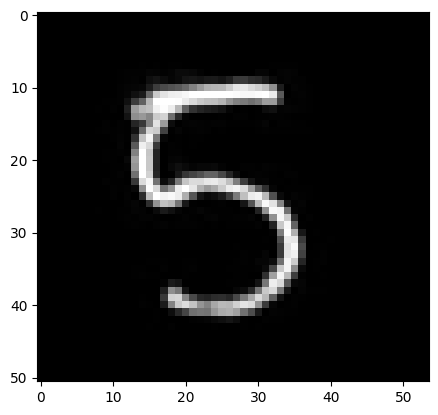

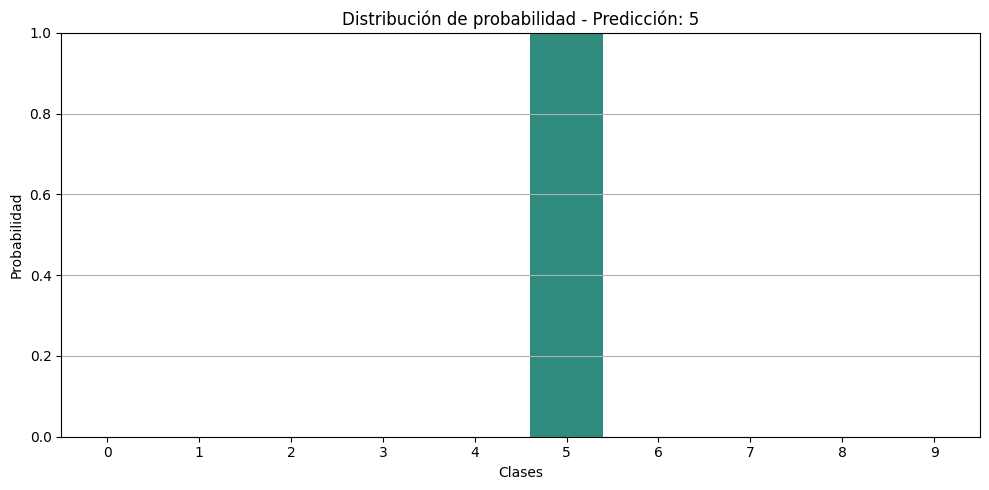

'5'

In [ ]:
predict_letter('/content/test/number/5.png')

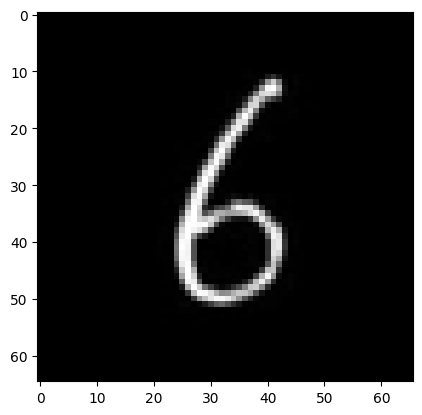

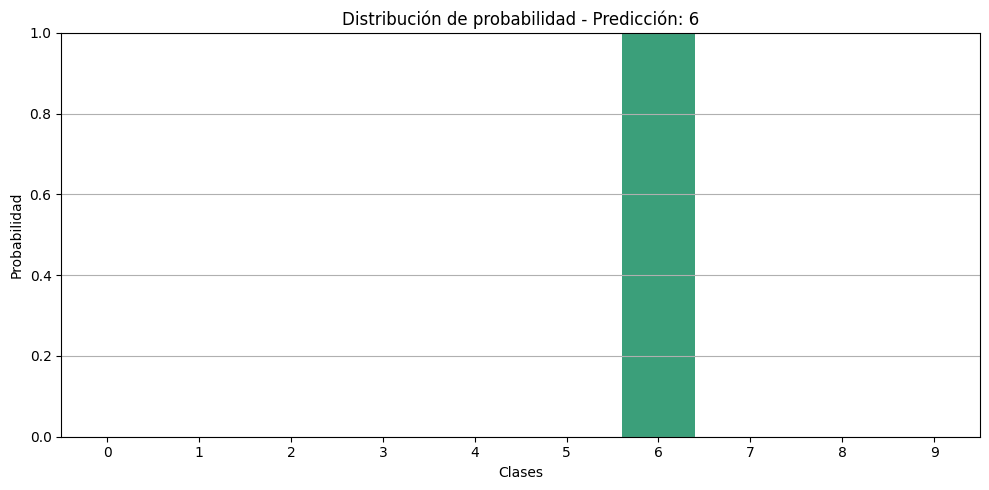

'6'

In [ ]:
predict_letter('/content/test/number/6.png')

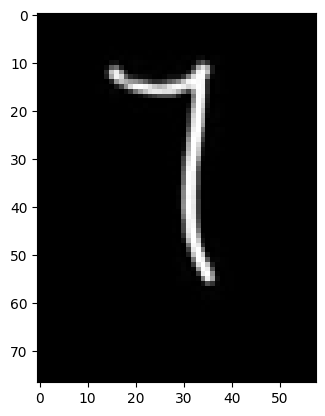

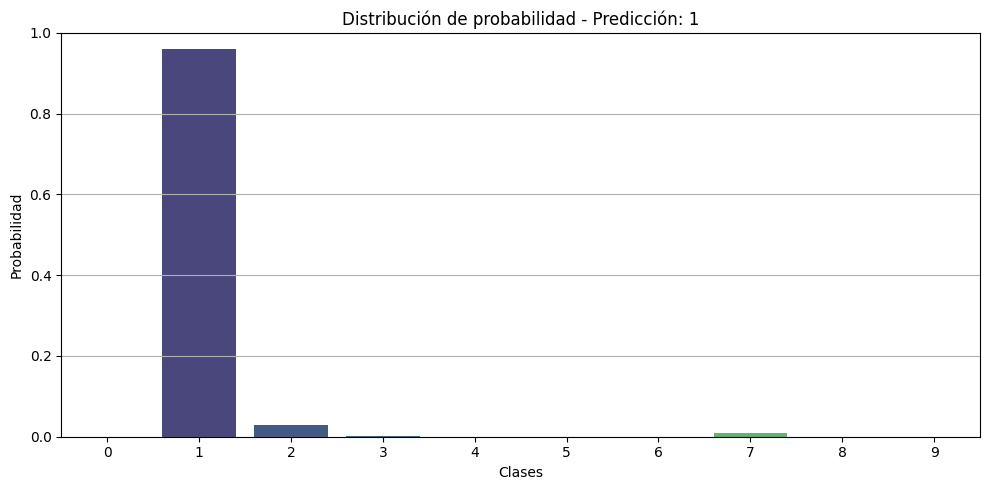

'1'

In [ ]:
predict_letter('/content/test/number/7.png')

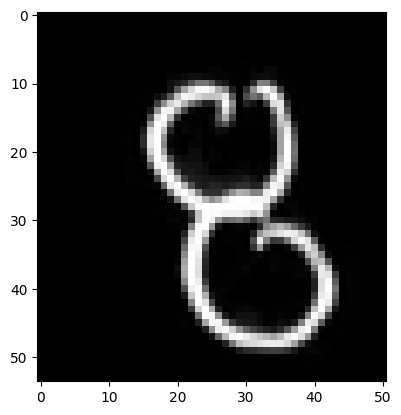

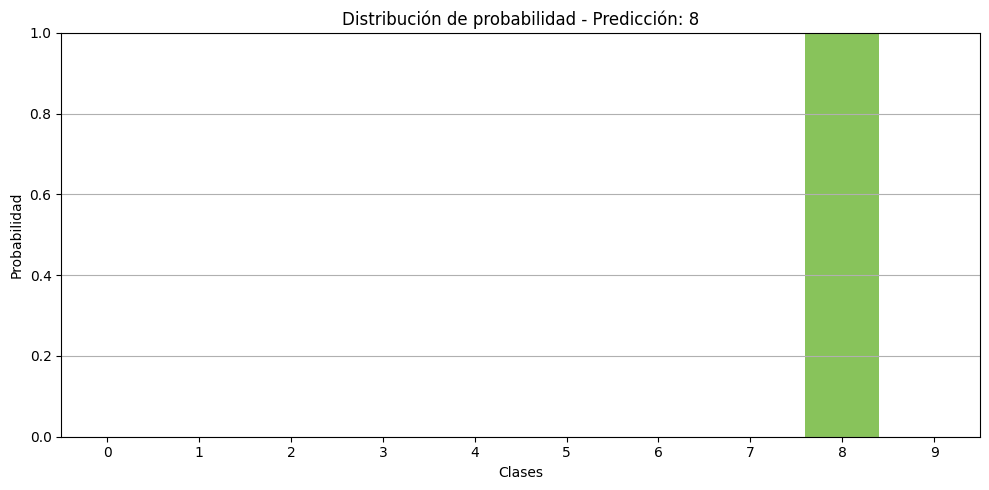

'8'

In [ ]:
predict_letter('/content/test/number/8.png')

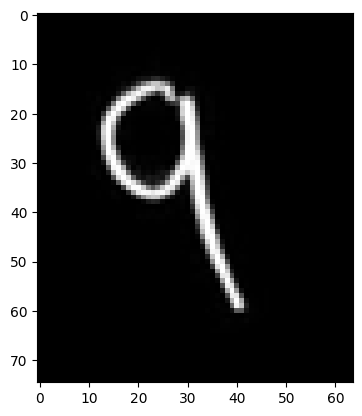

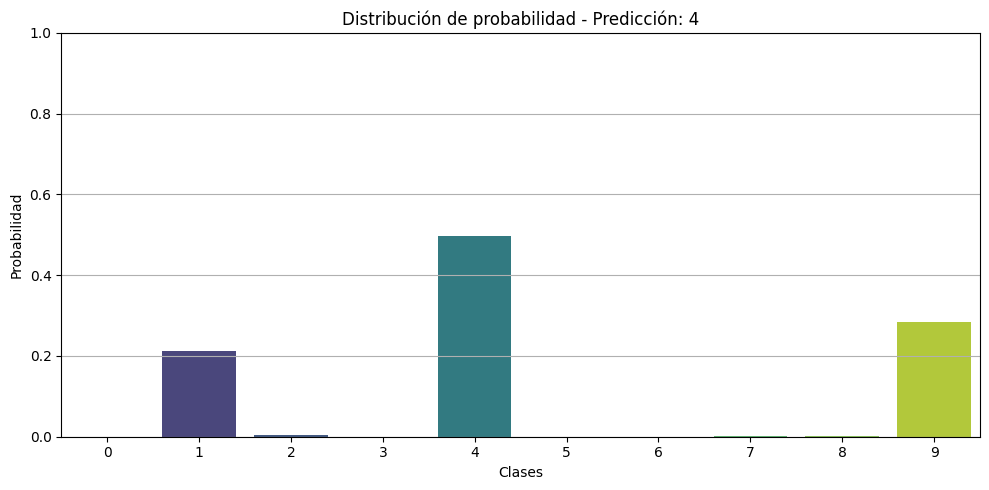

'4'

In [ ]:
predict_letter('/content/test/number/9.png')

#Conclusi√≥n n√∫meros normales
Como se observa en los numeros "normales" tuvo una acertividad de 8 de 10, donde se equivoco tanto en el 7 como en el 9 , y parece ser que es devido a que el 7 que escrib√≠ no tiene rayita en medio y el 9 al ser muy redondo y dejando un espacio peque√±o lo interpreto como 4 como probabilidad m√°xima, sin embargo el valor 9 tenia un 30% de probabilidades en su distribuci√≥n de probabilidad

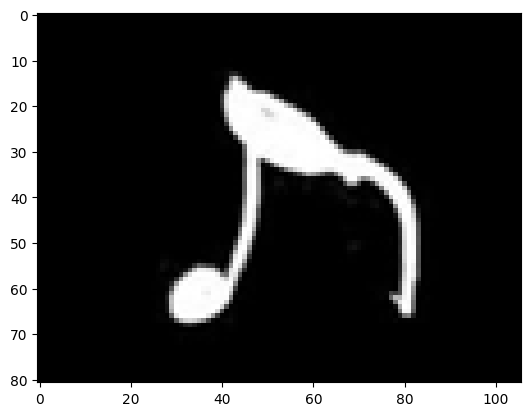

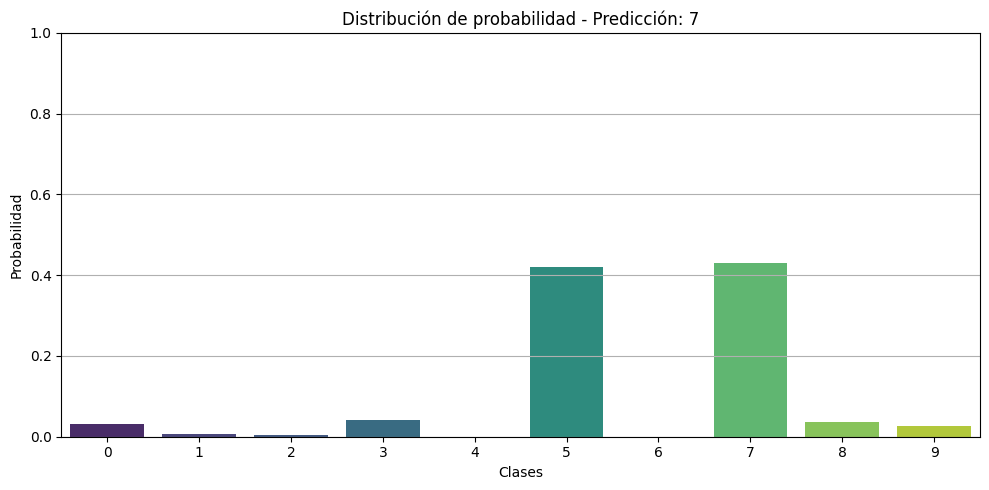

'7'

In [ ]:
predict_letter('/content/test/symbol/symbol1.png')

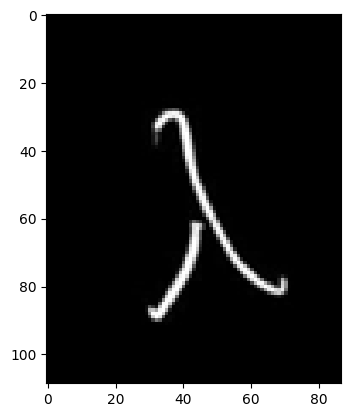

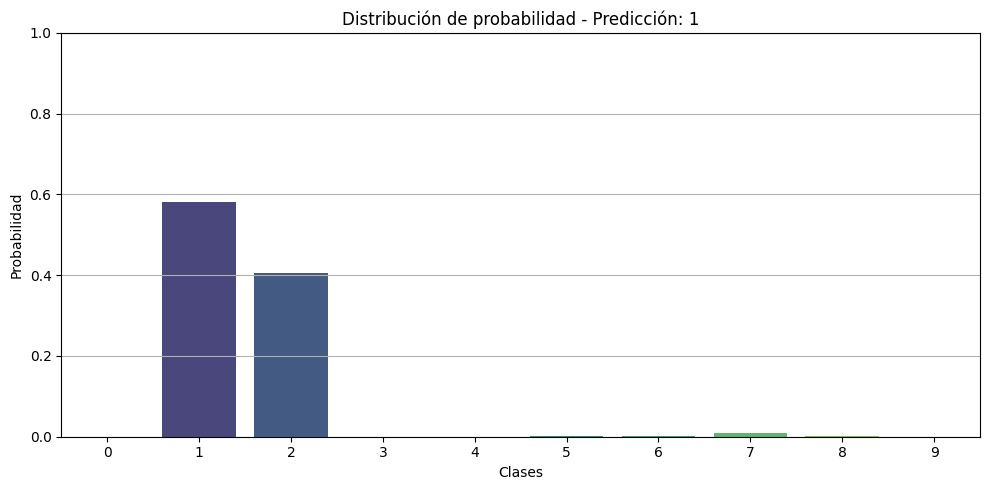

'1'

In [ ]:
predict_letter('/content/test/symbol/symbol2.png')

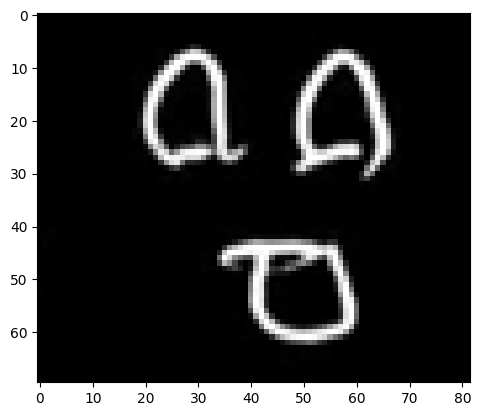

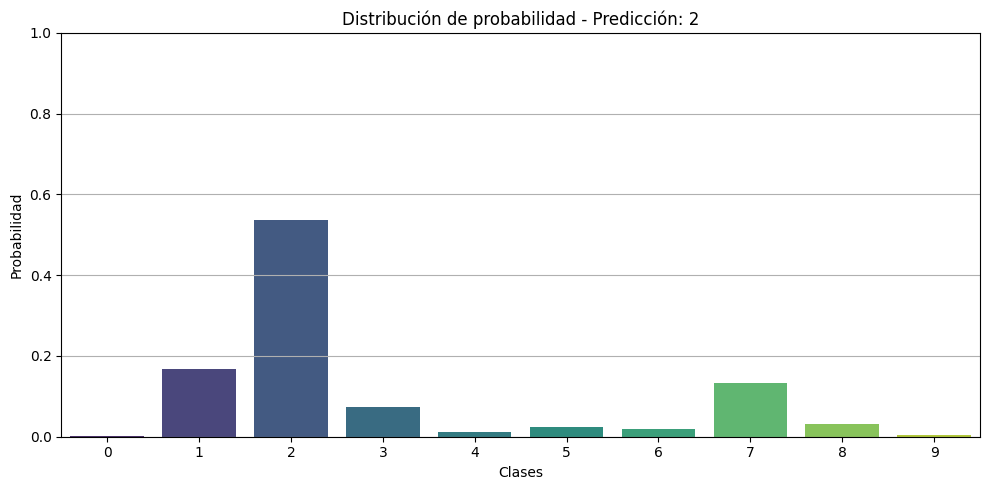

'2'

In [ ]:
predict_letter('/content/test/symbol/symbol3.png')

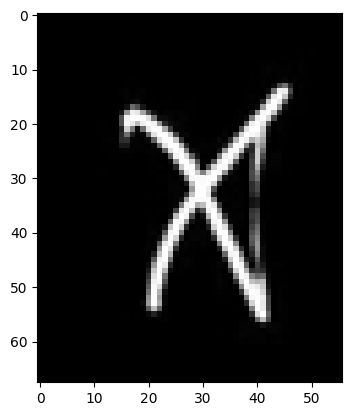

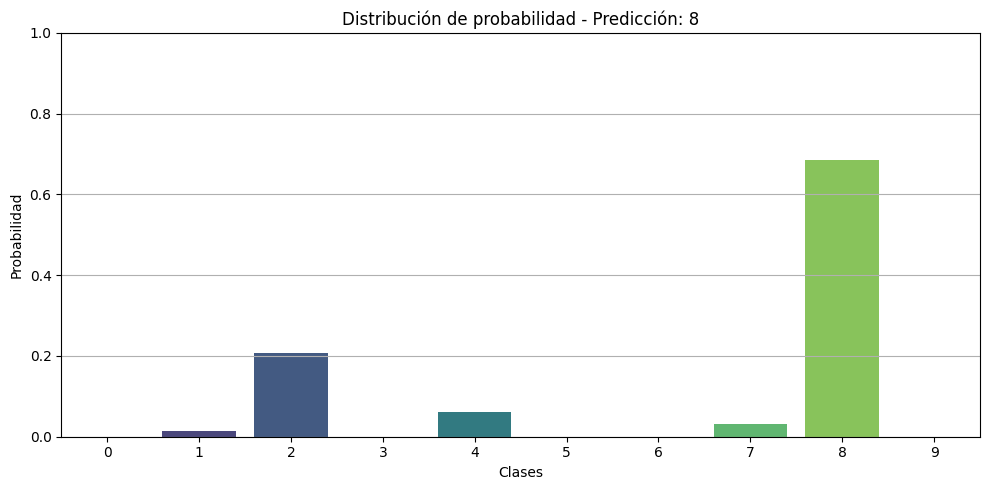

'8'

In [ ]:
predict_letter('/content/test/symbol/symbol4.png')

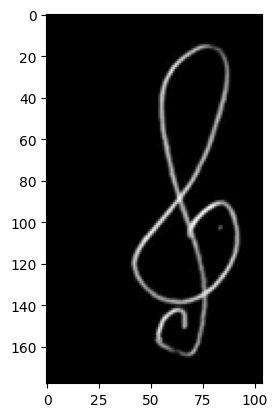

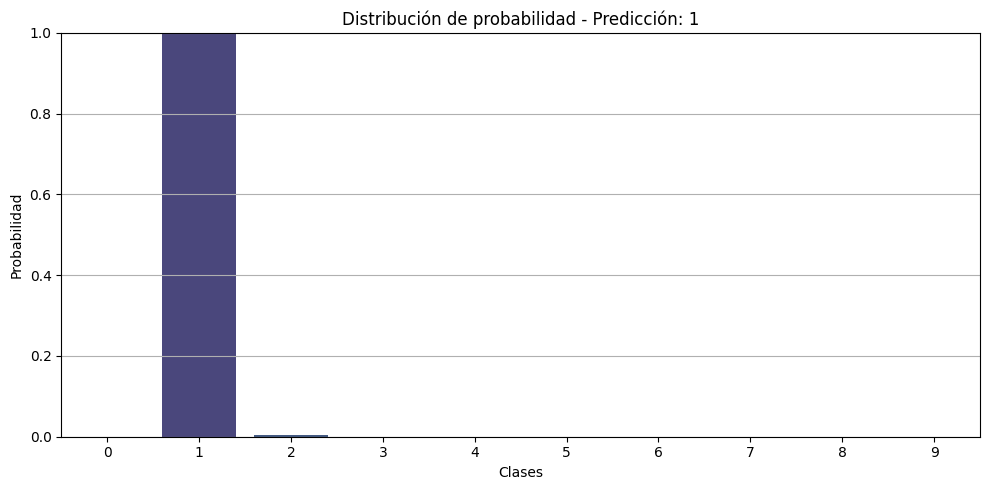

'1'

In [ ]:
predict_letter('/content/test/symbol/symbol5.png')

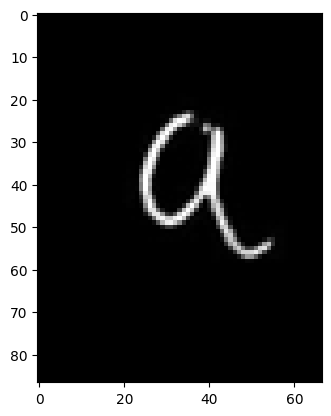

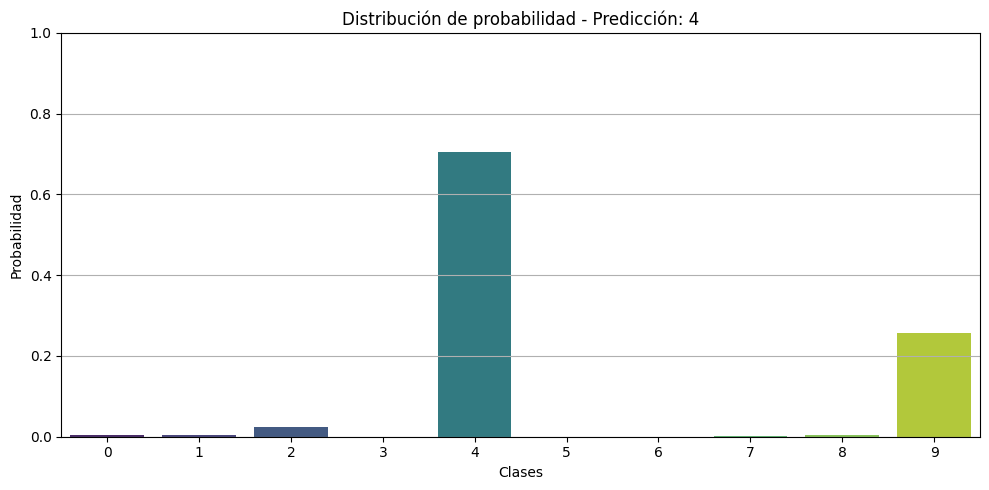

'4'

In [ ]:
predict_letter('/content/test/symbol/symbol6.png')

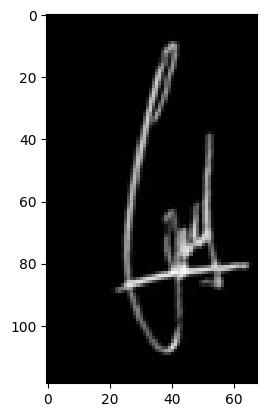

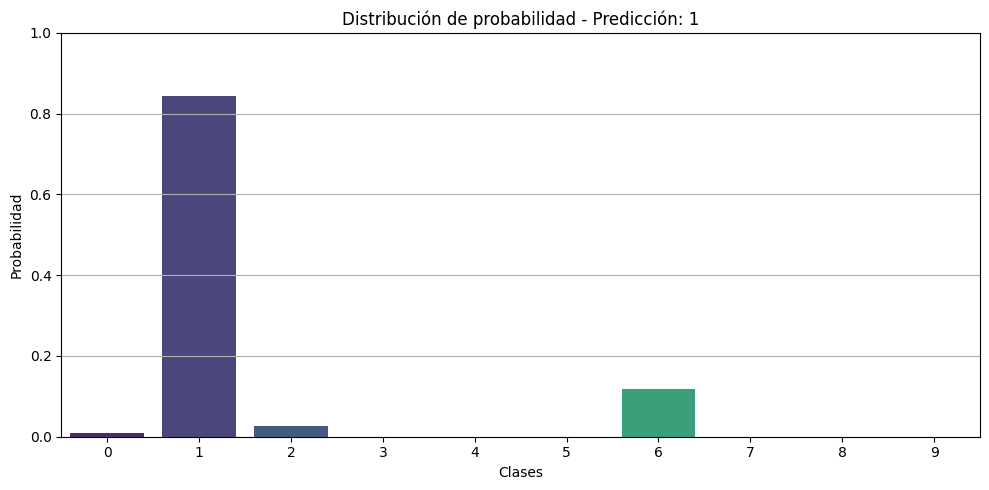

'1'

In [ ]:
predict_letter('/content/test/symbol/symbol7.png')

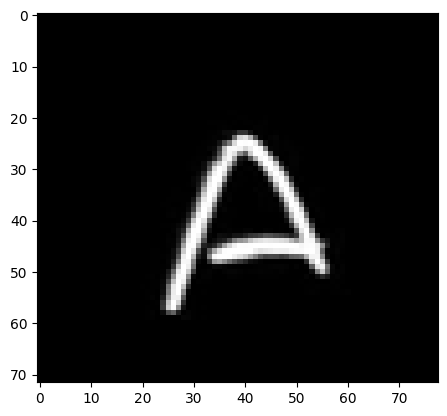

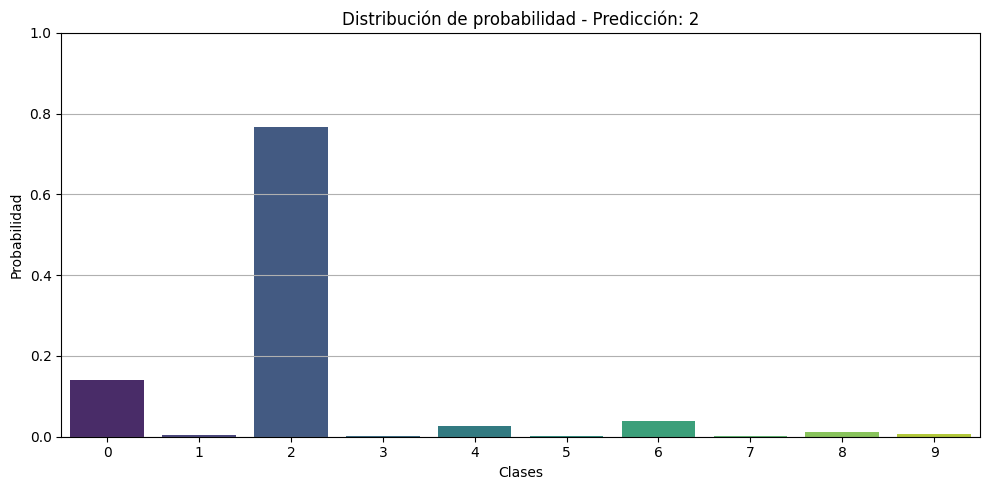

'2'

In [ ]:
predict_letter('/content/test/symbol/symbol8.png')

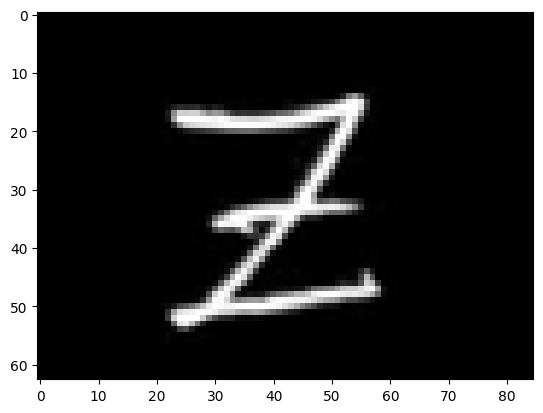

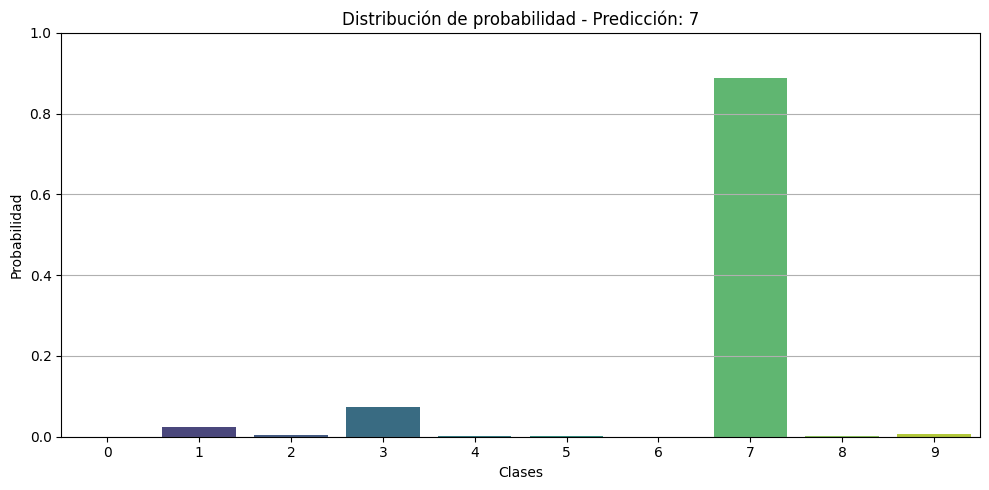

'7'

In [ ]:
predict_letter('/content/test/symbol/symbol9.png')

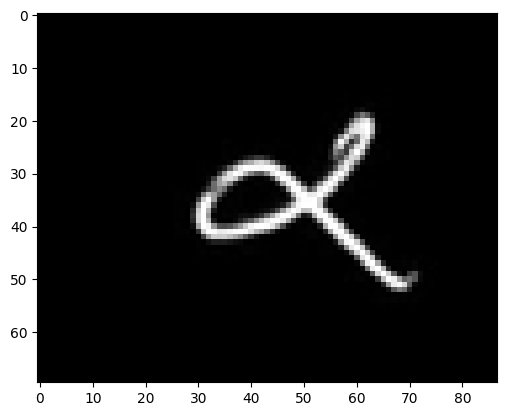

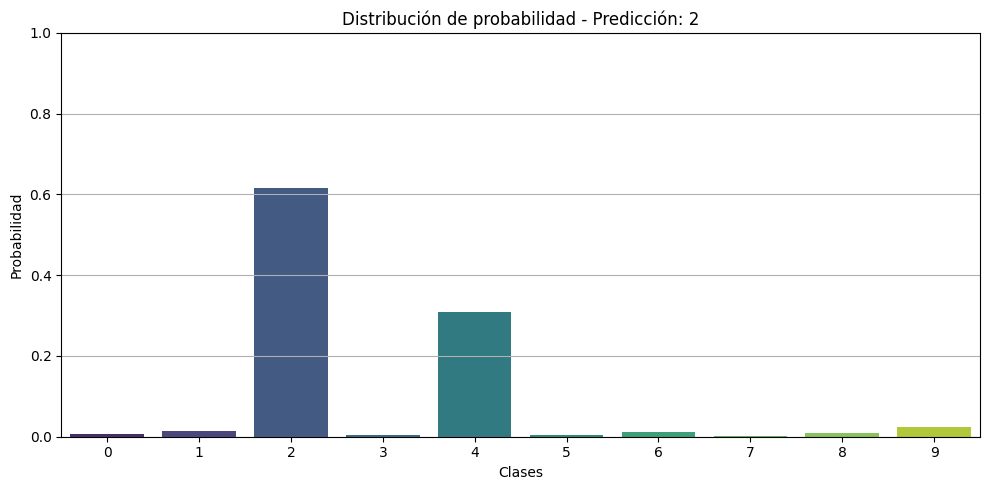

'2'

In [ ]:
predict_letter('/content/test/symbol/symbol10.png')

#Conclusi√≥n de symbolos
Con respecto a los simbolos, por obvias razones el modelo no predeciria una clasificaci√≥n que no tiene integrado, sin embargo el modelo para ser que se baso en caracteristicas bastante complejas, no aptas para el ojo humano para predecir, un claro ejemplo es la clave sol "ùÑû" que a simple vista uno diria que el n√∫mero mas cercano a parecerse es el 8 sin embargo el modelo predijo que es el 1, lo cual esta bastante alejado de la forma de la clave sol

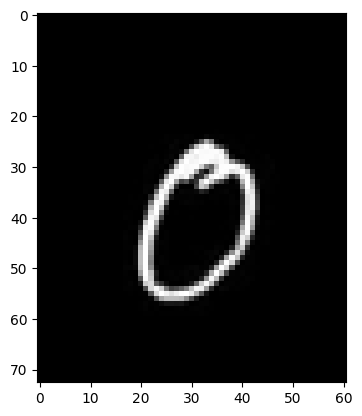

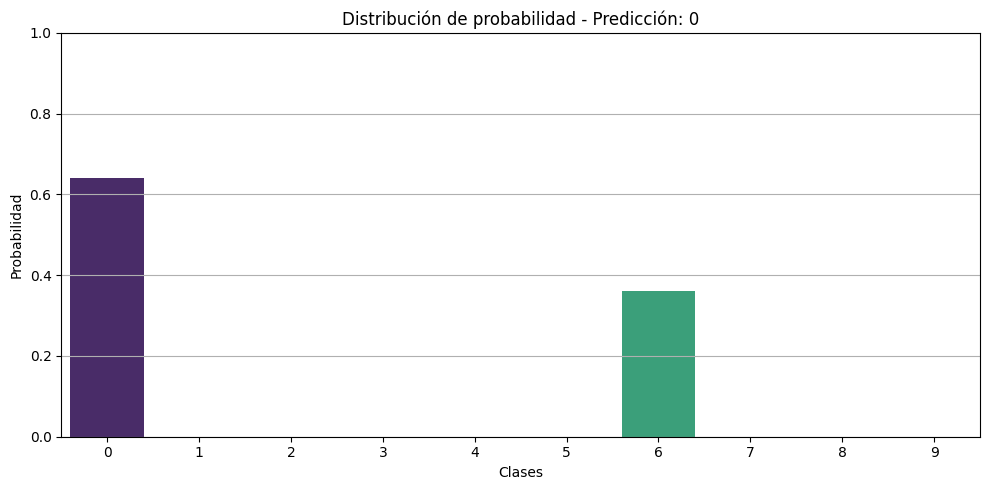

'0'

In [ ]:
predict_letter('/content/test/rotation/0.png')

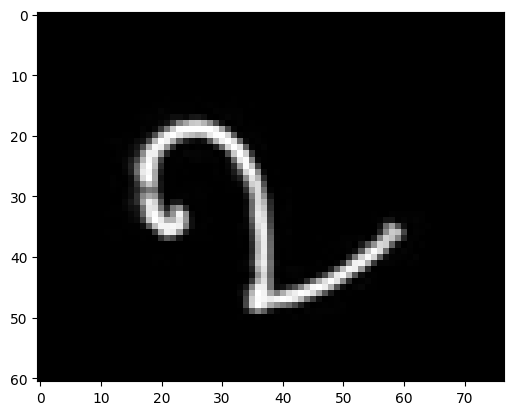

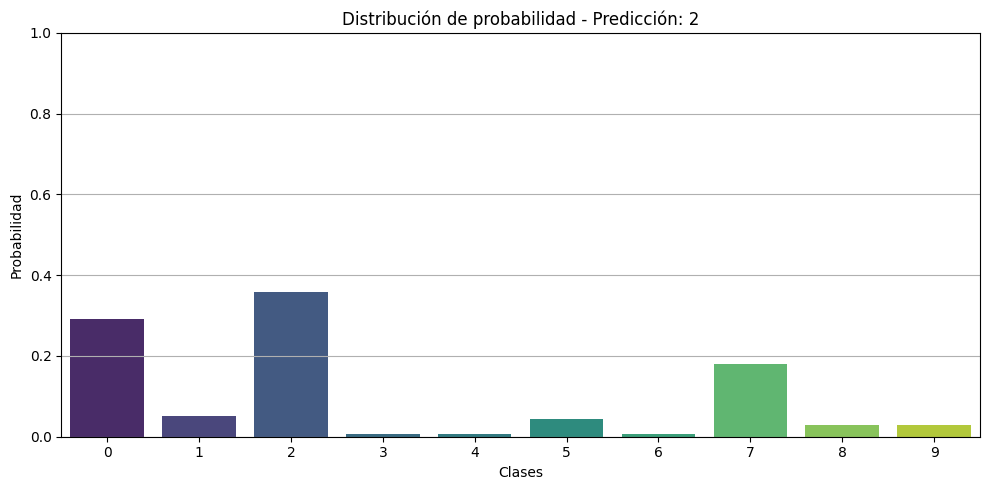

'2'

In [ ]:
predict_letter('/content/test/rotation/2.png')

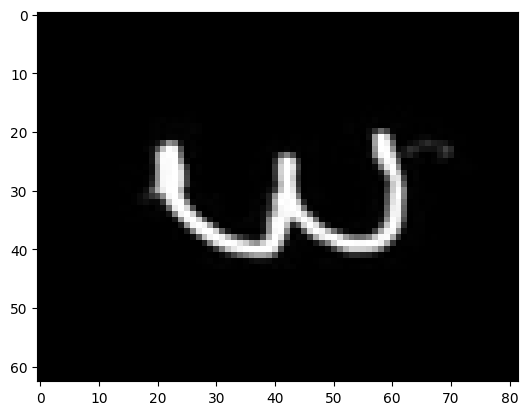

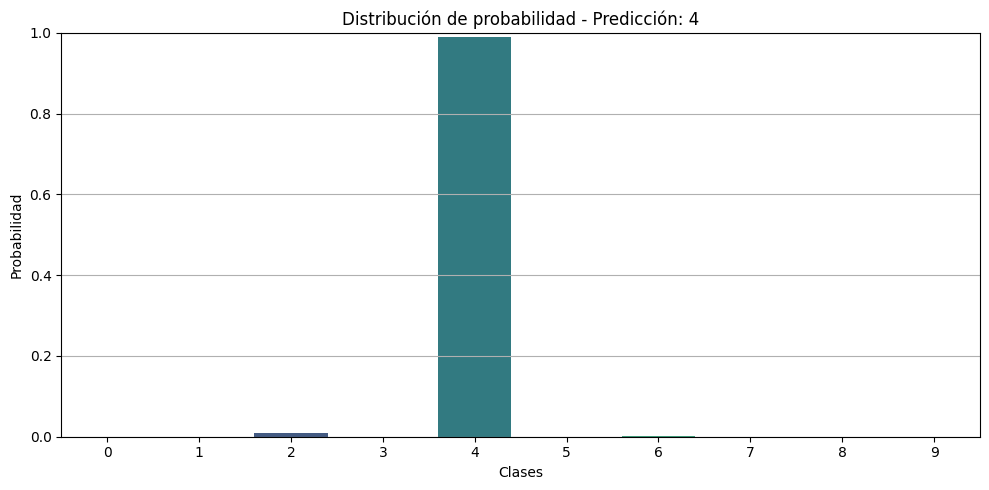

'4'

In [ ]:
predict_letter('/content/test/rotation/3.png')

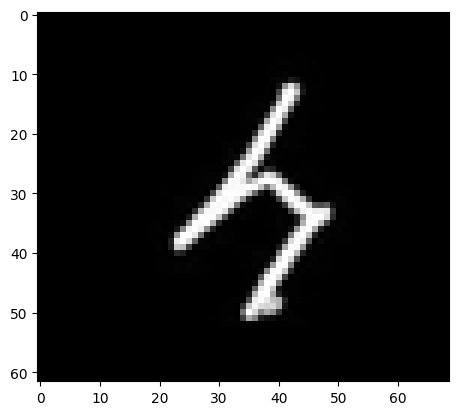

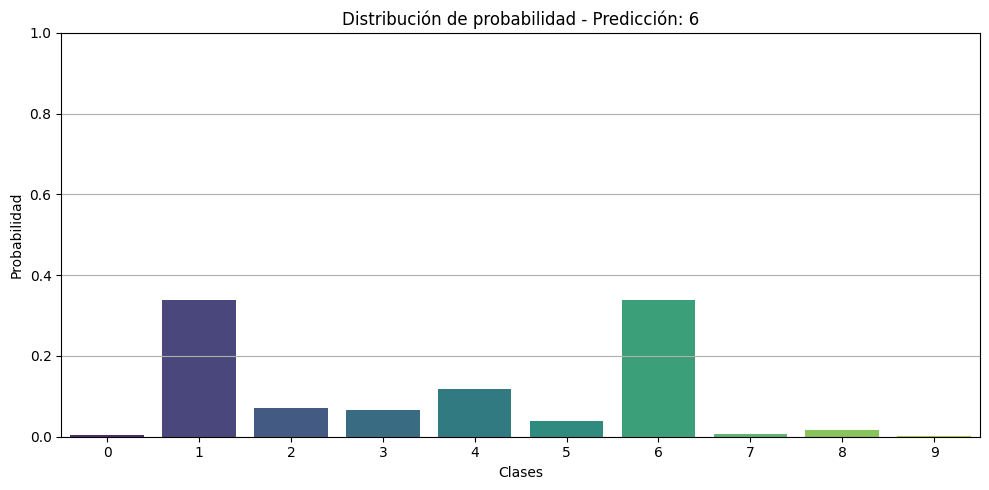

'6'

In [ ]:
predict_letter('/content/test/rotation/4.png')

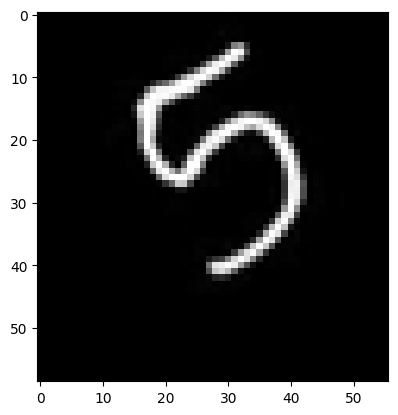

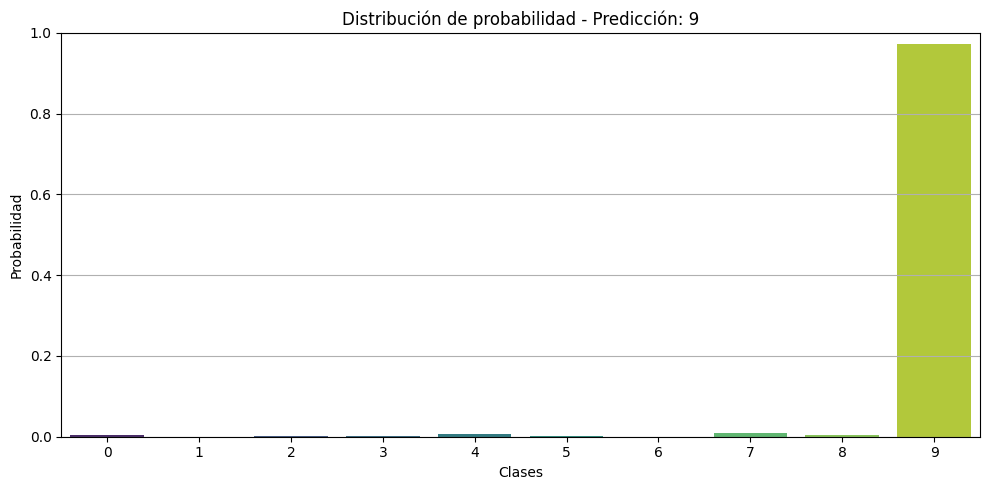

'9'

In [ ]:
predict_letter('/content/test/rotation/5.png')

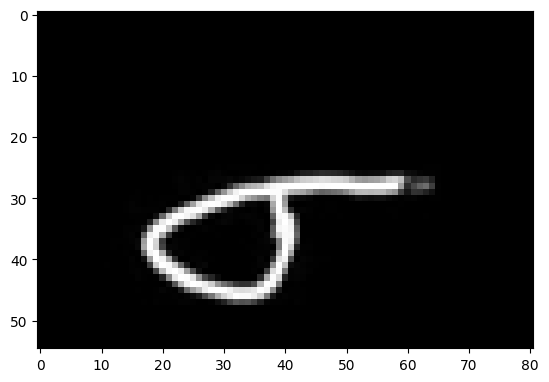

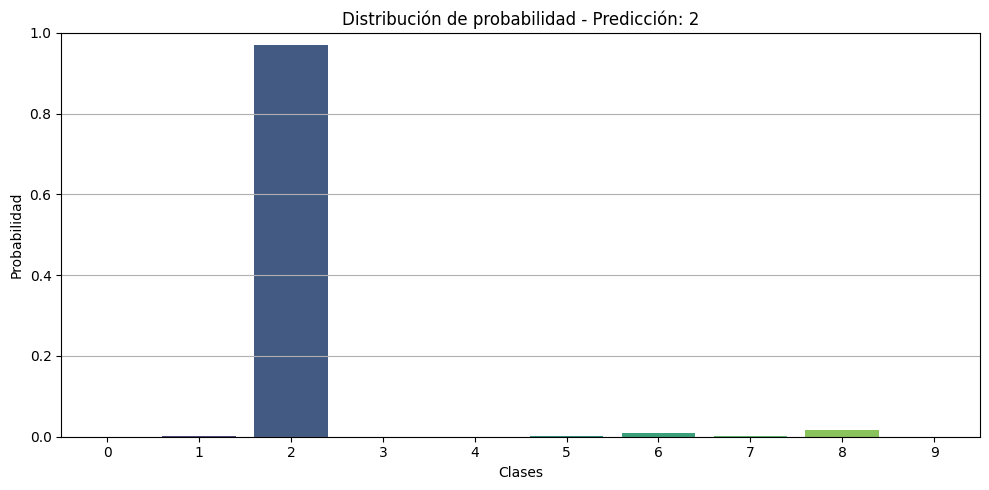

'2'

In [ ]:
predict_letter('/content/test/rotation/6.png')

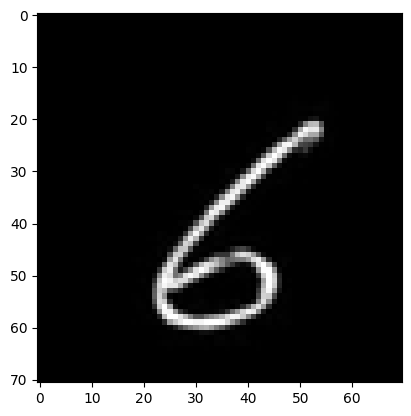

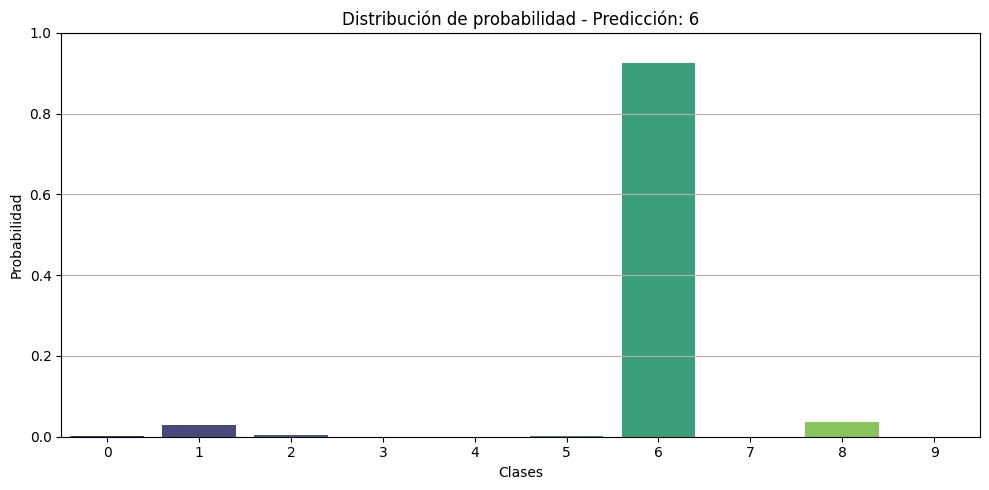

'6'

In [ ]:
predict_letter('/content/test/rotation/6 (2).png')

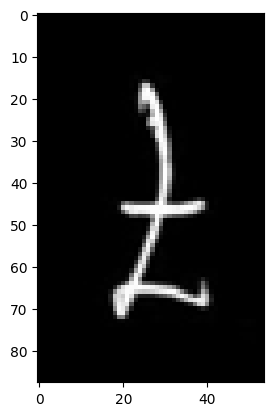

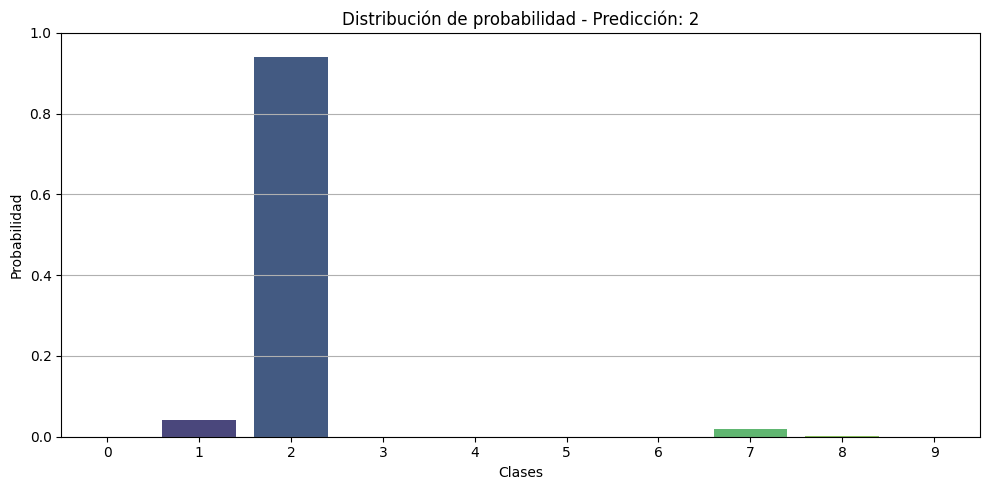

'2'

In [ ]:
predict_letter('/content/test/rotation/7.png')

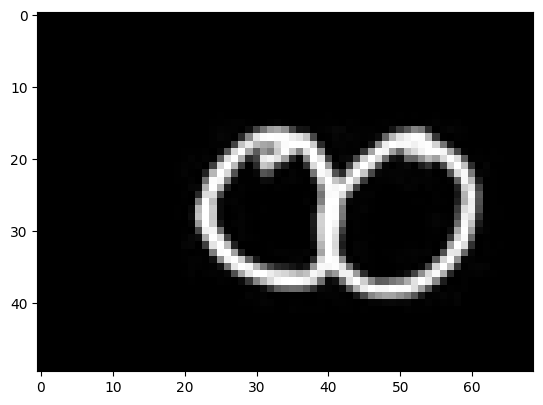

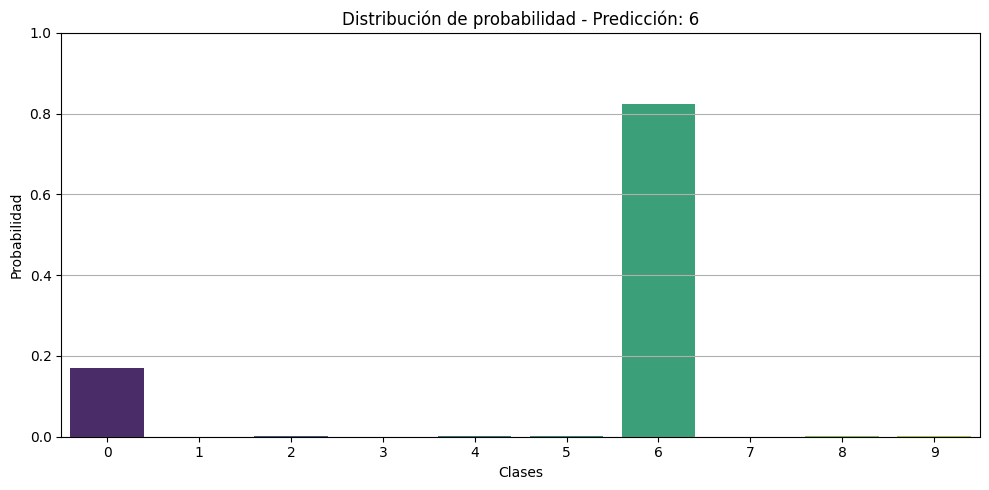

'6'

In [ ]:
predict_letter('/content/test/rotation/8.png')

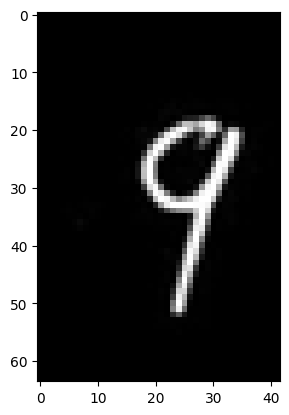

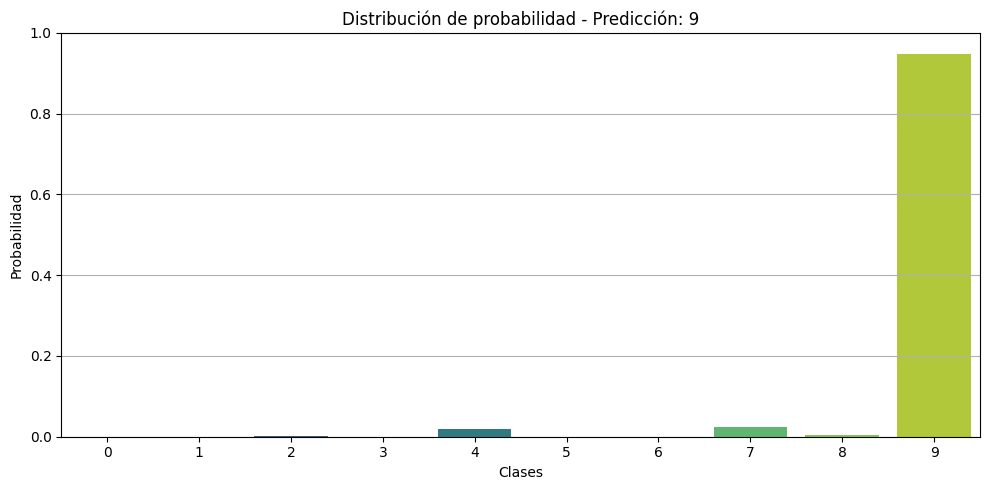

'9'

In [ ]:
predict_letter('/content/test/rotation/9.png')

#Conclusi√≥n n√∫mero con rotaci√≥n
Las rotaciones representan un desaf√≠o considerable para el modelo de reconocimiento de d√≠gitos basado en MNIST. La precisi√≥n obtenida fue de apenas 4 aciertos sobre 10, lo que evidencia que el modelo no generaliza bien ante variaciones angulares en las im√°genes. En varios casos, la clase correcta no solo dej√≥ de ser la opci√≥n m√°s probable, sino que fue desplazada por otras con baja diferencia de probabilidad, indicando una alta incertidumbre en la predicci√≥n.

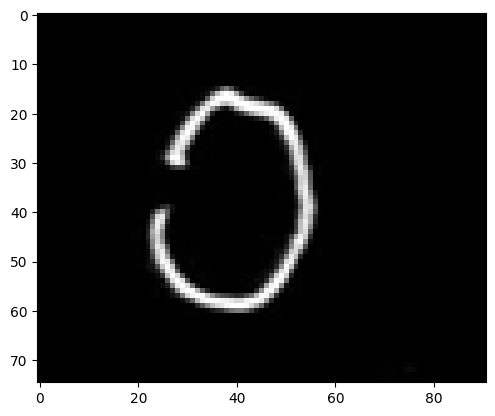

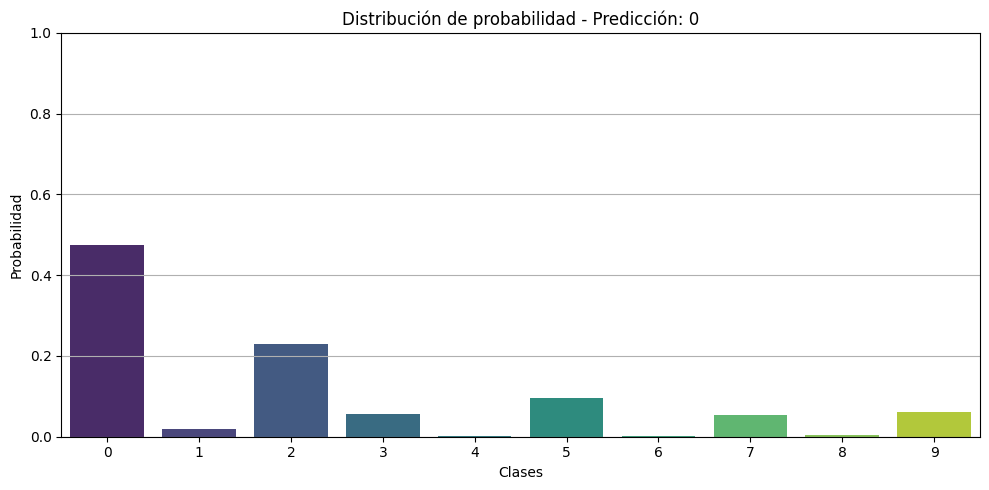

'0'

In [ ]:
predict_letter('/content/test/blot/0.png')

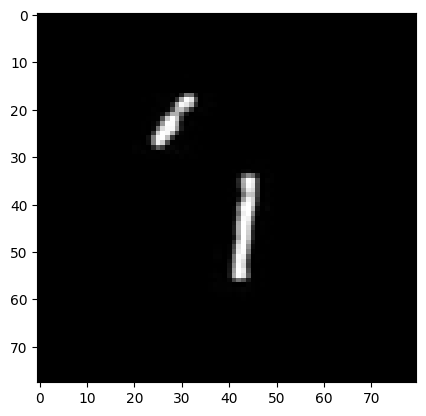

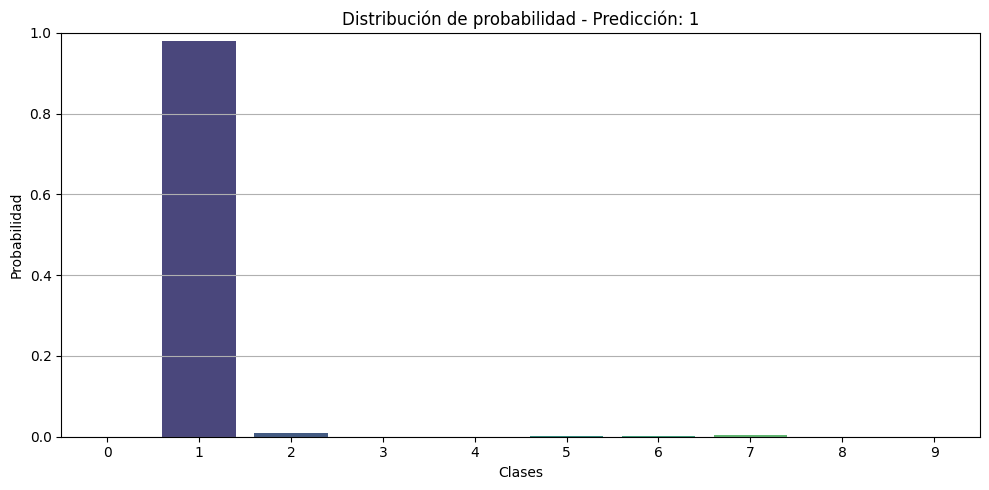

'1'

In [ ]:
predict_letter('/content/test/blot/1.png')

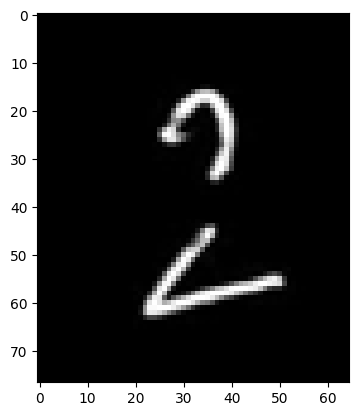

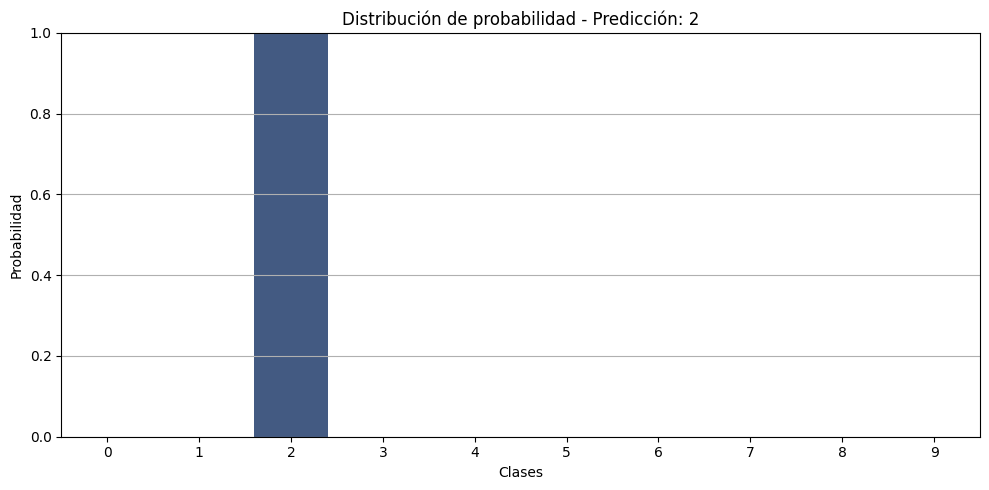

'2'

In [ ]:
predict_letter('/content/test/blot/2.png')

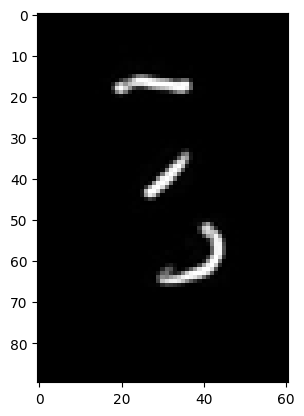

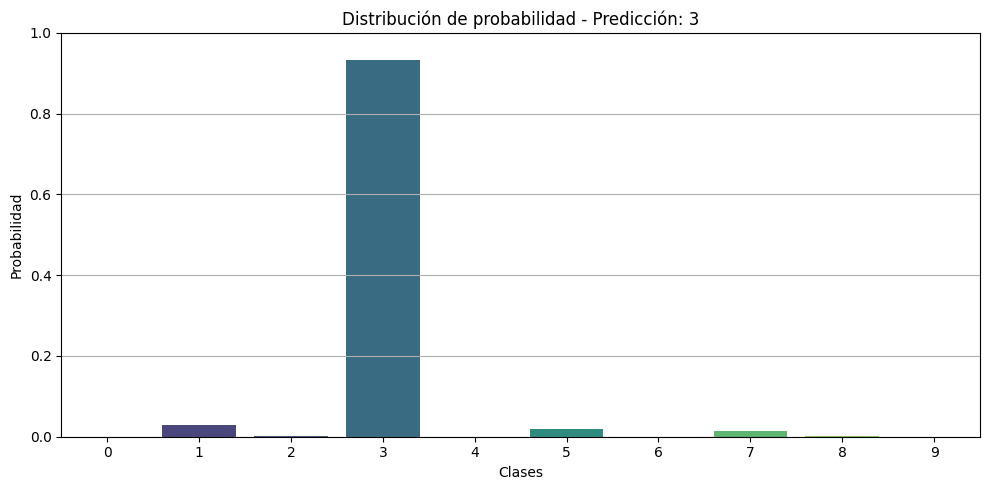

'3'

In [ ]:
predict_letter('/content/test/blot/3.png')

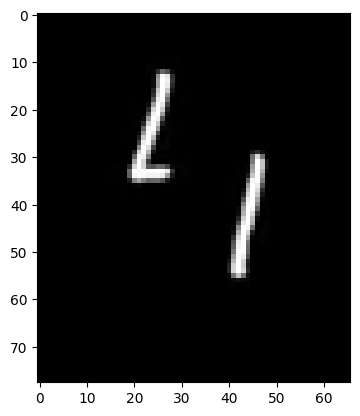

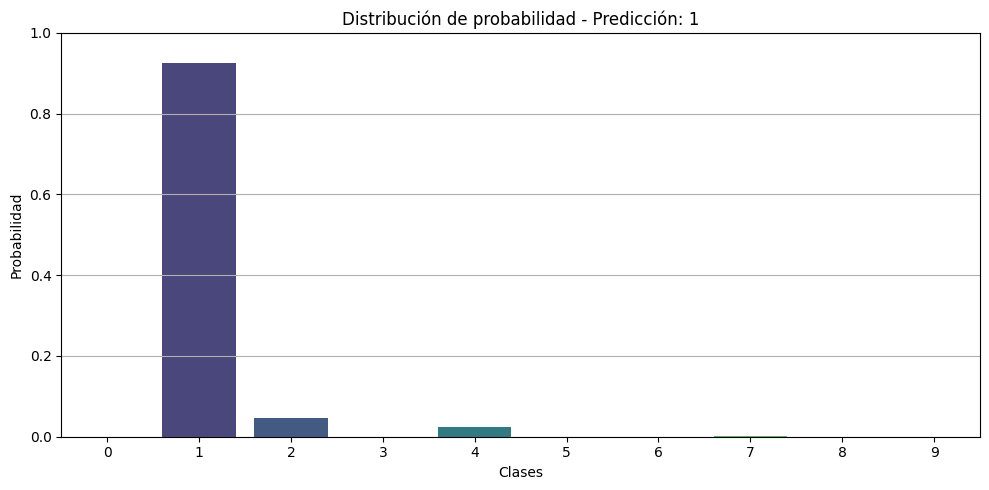

'1'

In [ ]:
predict_letter('/content/test/blot/4.png')

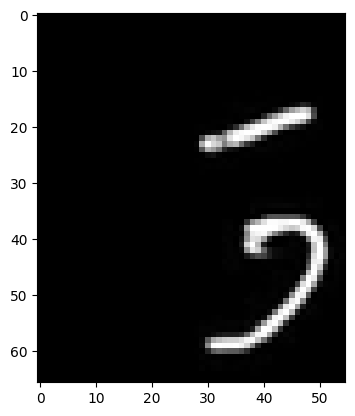

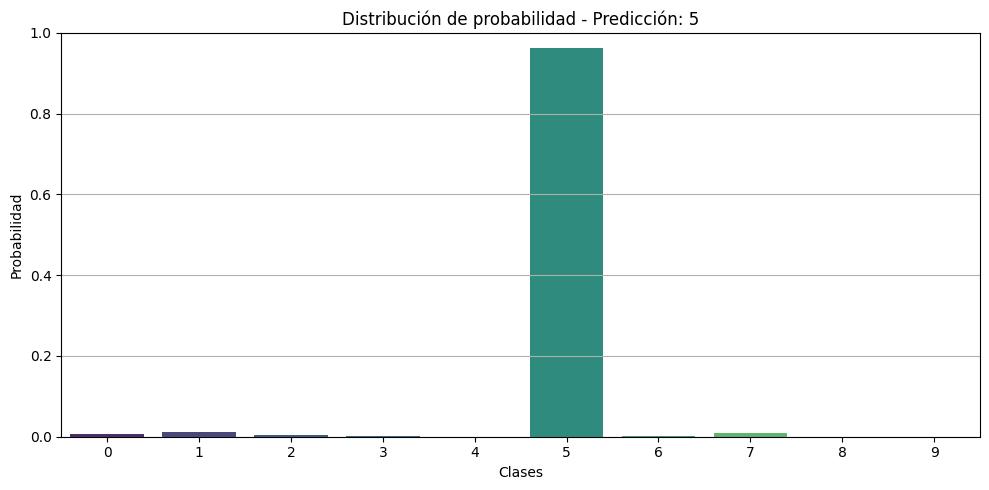

'5'

In [ ]:
predict_letter('/content/test/blot/5.png')

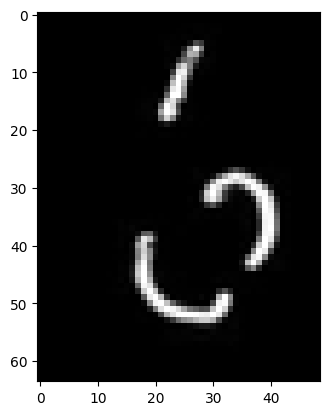

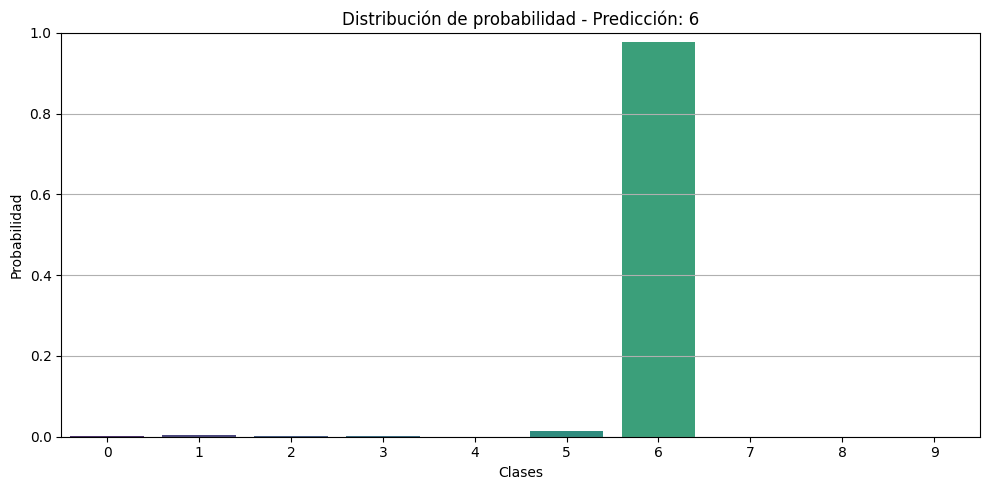

'6'

In [ ]:
predict_letter('/content/test/blot/6.png')

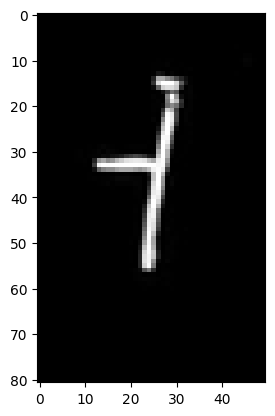

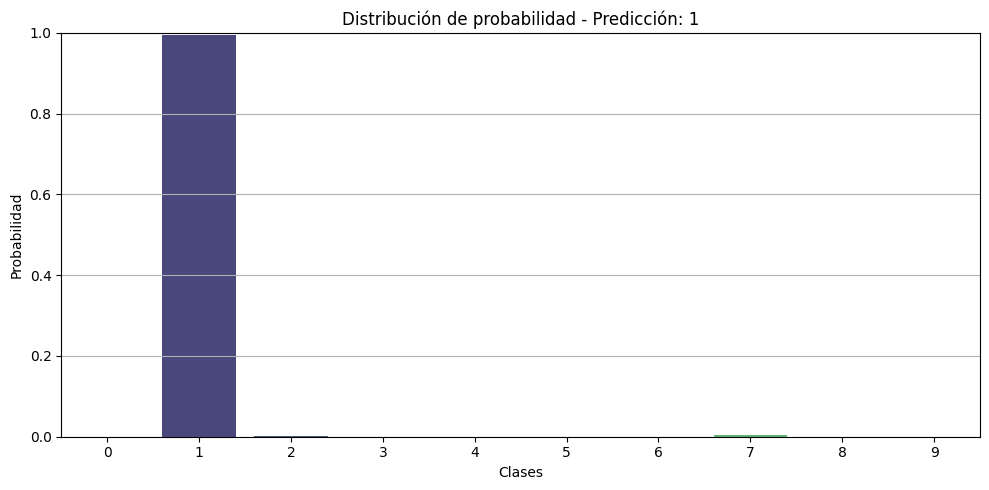

'1'

In [ ]:
predict_letter('/content/test/blot/7.png')

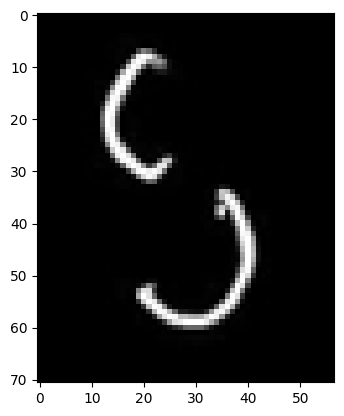

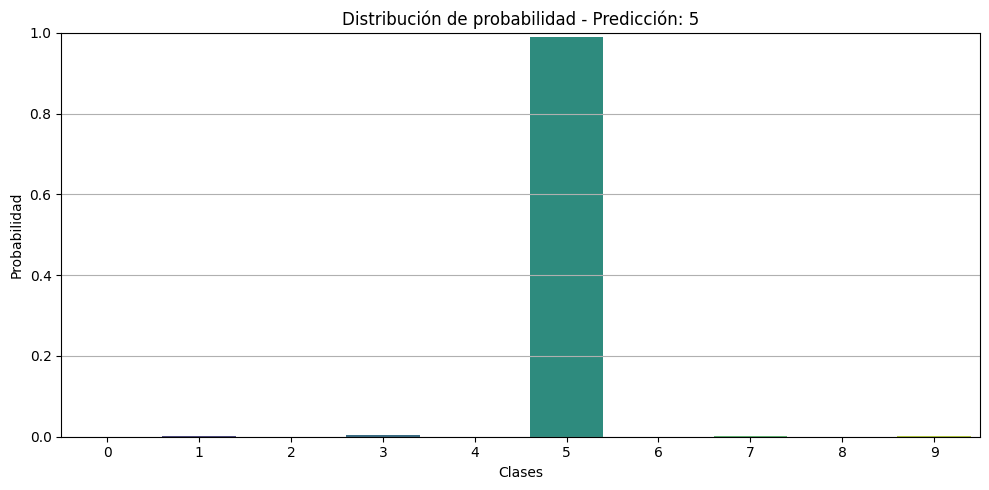

'5'

In [ ]:
predict_letter('/content/test/blot/8.png')

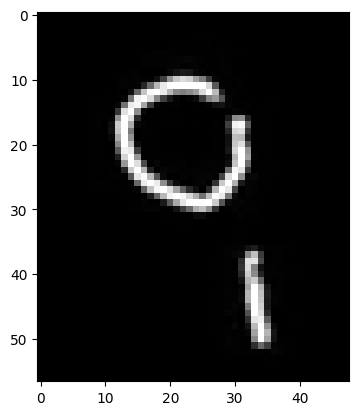

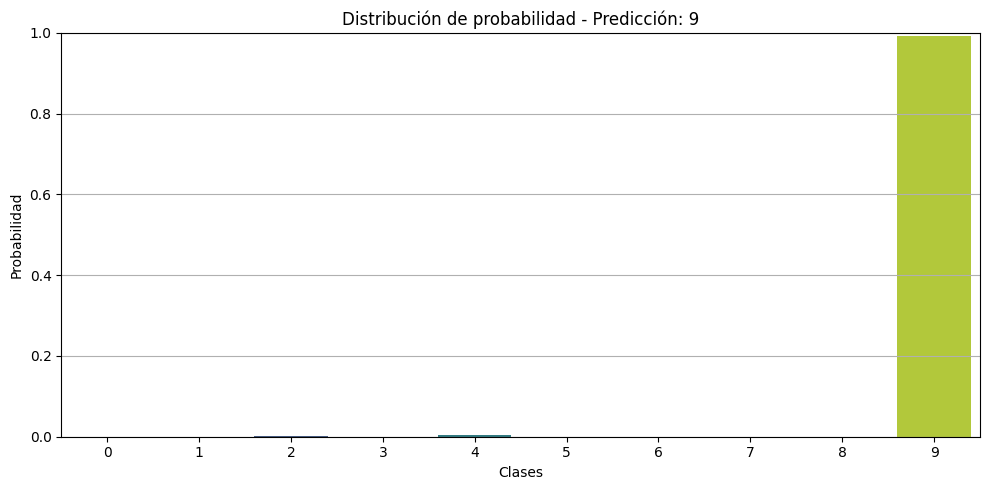

'9'

In [ ]:
predict_letter('/content/test/blot/9.png')

#Conclusi√≥n n√∫meros con borrones
En el caso de los n√∫meros con borrones, el modelo logr√≥ una precisi√≥n de aproximadamente 6 de 10, lo cual indica una capacidad moderada de generalizaci√≥n ante im√°genes deterioradas. Este rendimiento puede atribuirse en parte al uso de t√©cnicas como dropout durante el entrenamiento, que ayudan al modelo a volverse m√°s robusto al obligarlo a aprender patrones relevantes incluso cuando partes de la informaci√≥n visual est√°n ausentes.

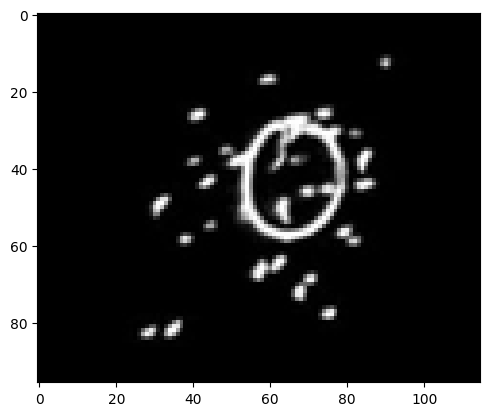

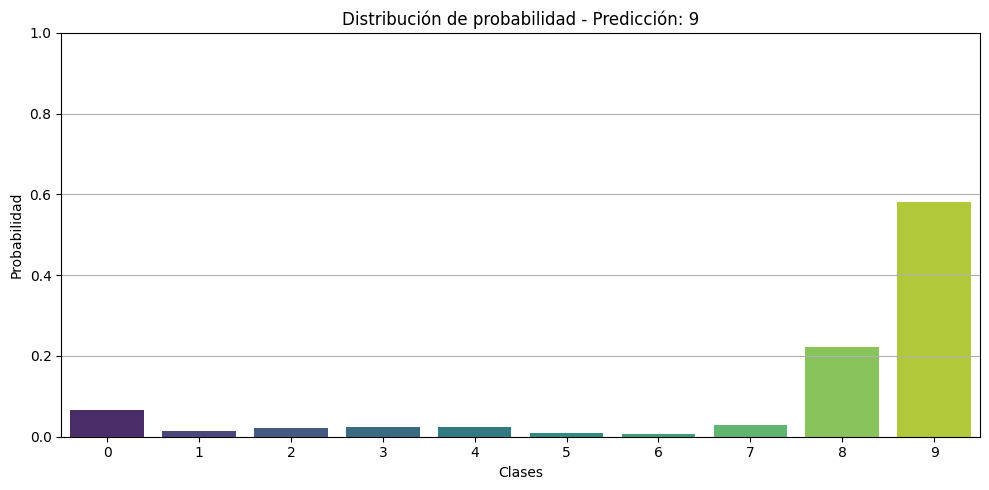

'9'

In [ ]:
predict_letter('/content/test/noise/0.png')

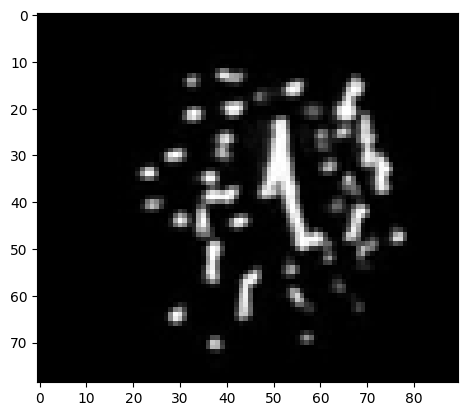

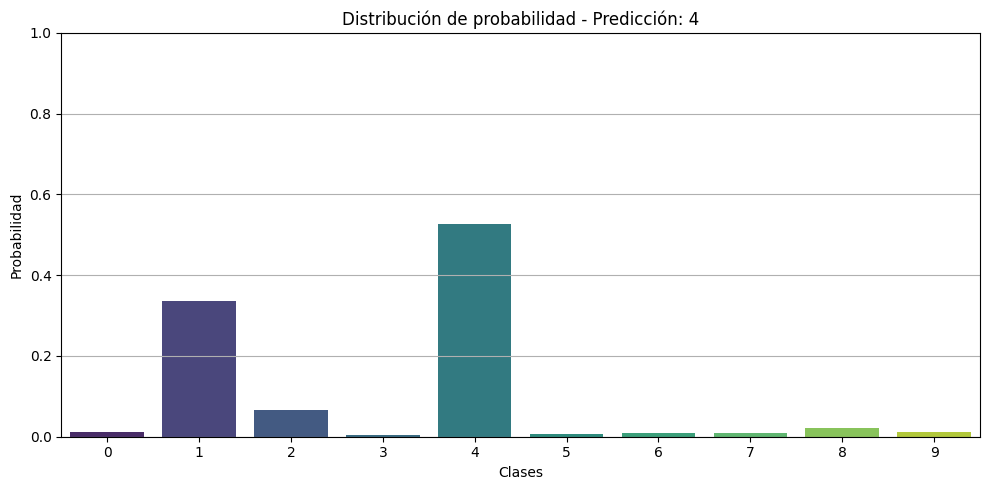

'4'

In [ ]:
predict_letter('/content/test/noise/1.png')

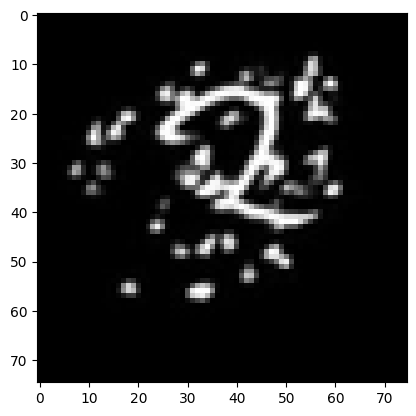

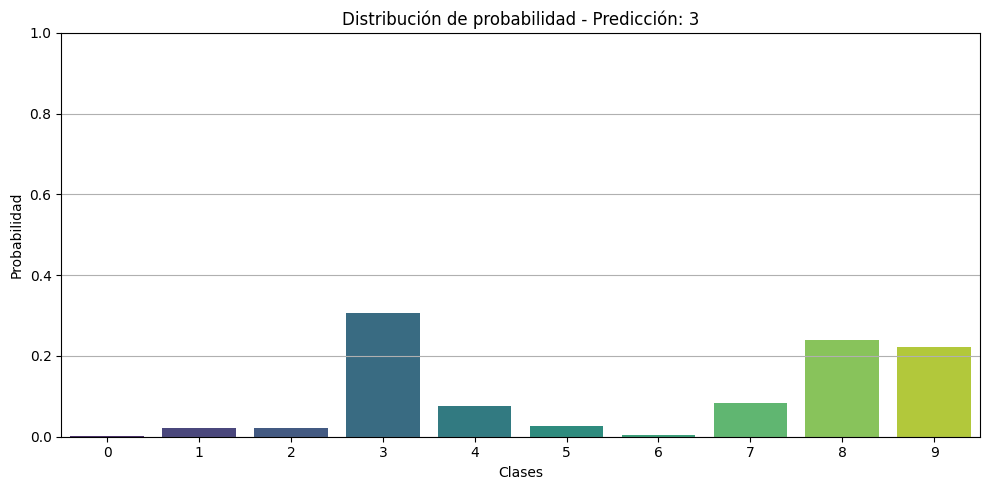

'3'

In [ ]:
predict_letter('/content/test/noise/2.png')

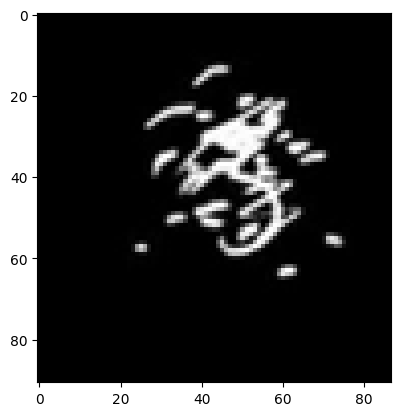

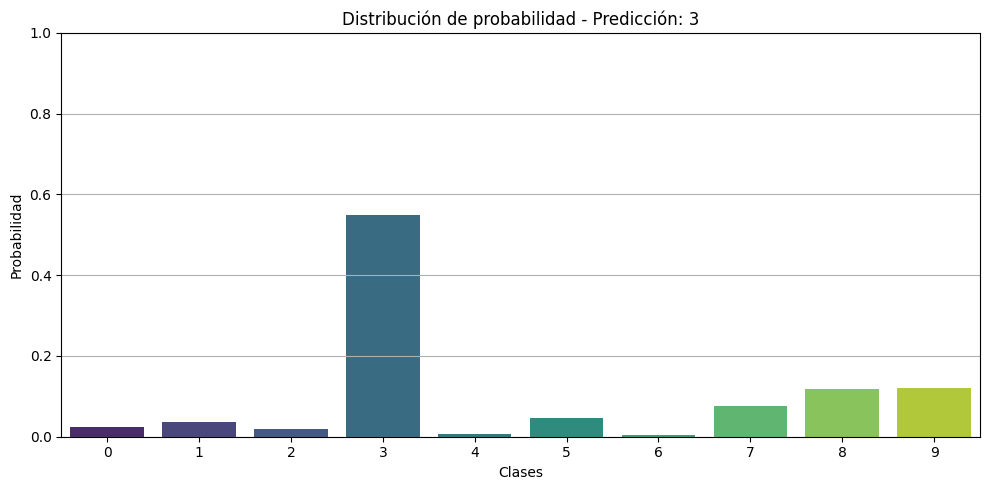

'3'

In [ ]:
predict_letter('/content/test/noise/3.png')

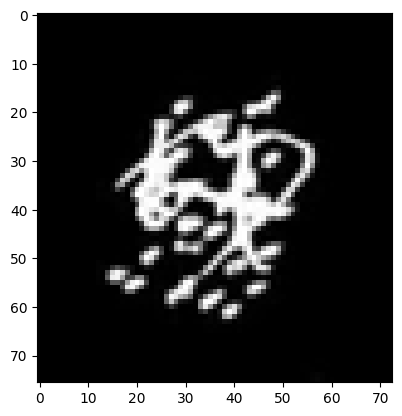

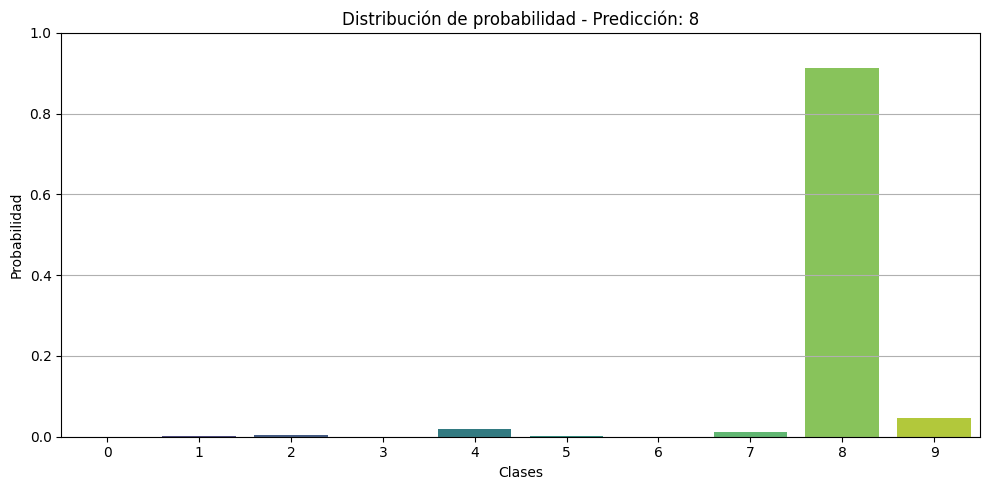

'8'

In [ ]:
predict_letter('/content/test/noise/4.png')

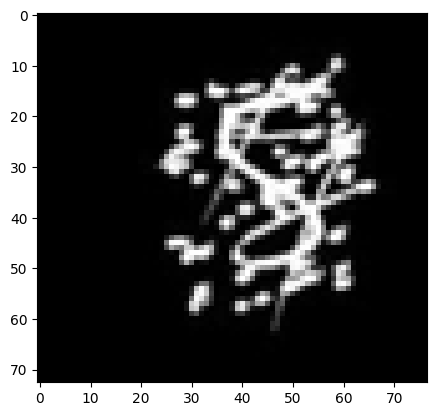

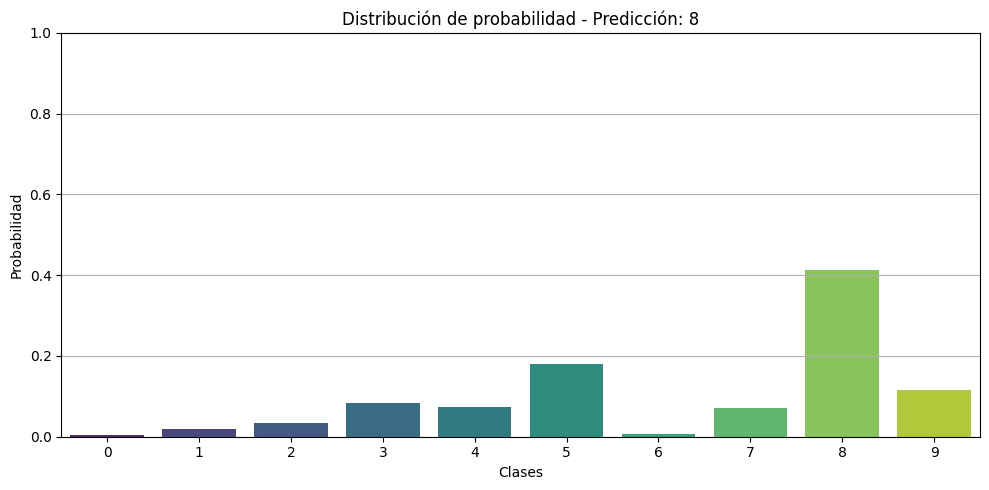

'8'

In [ ]:
predict_letter('/content/test/noise/5.png')

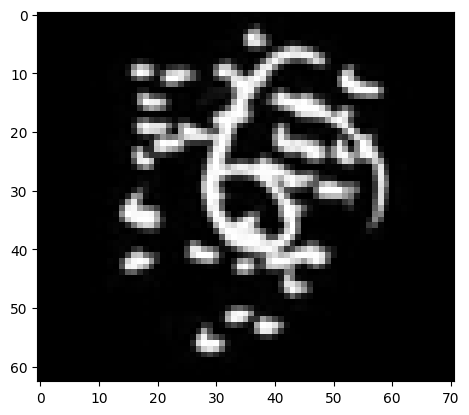

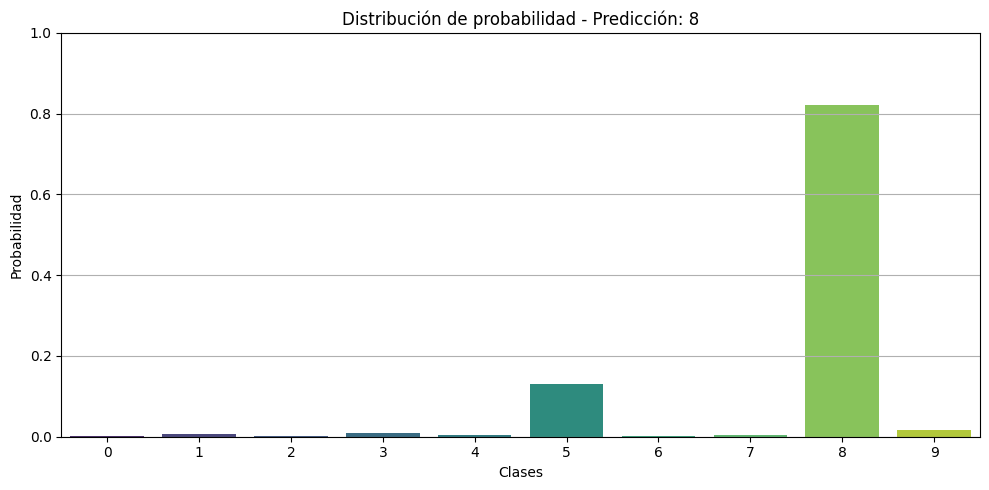

'8'

In [ ]:
predict_letter('/content/test/noise/6.png')

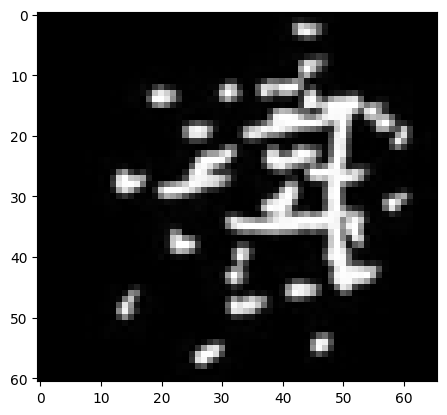

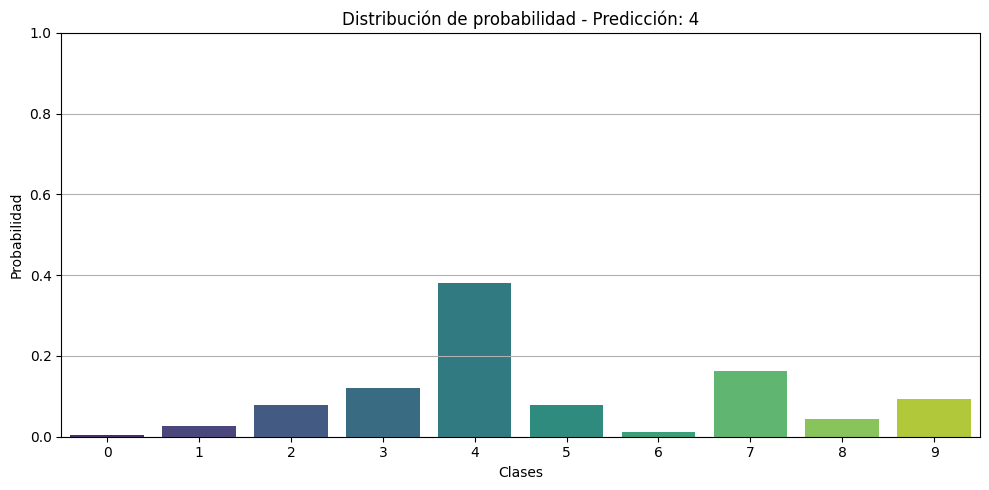

'4'

In [ ]:
predict_letter('/content/test/noise/7.png')

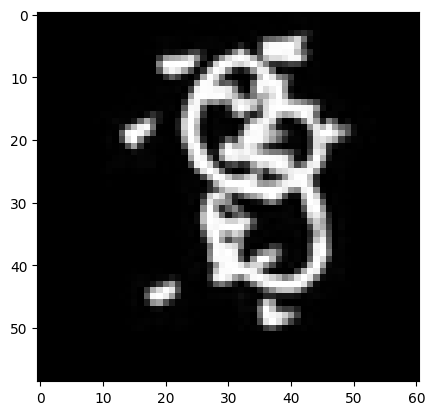

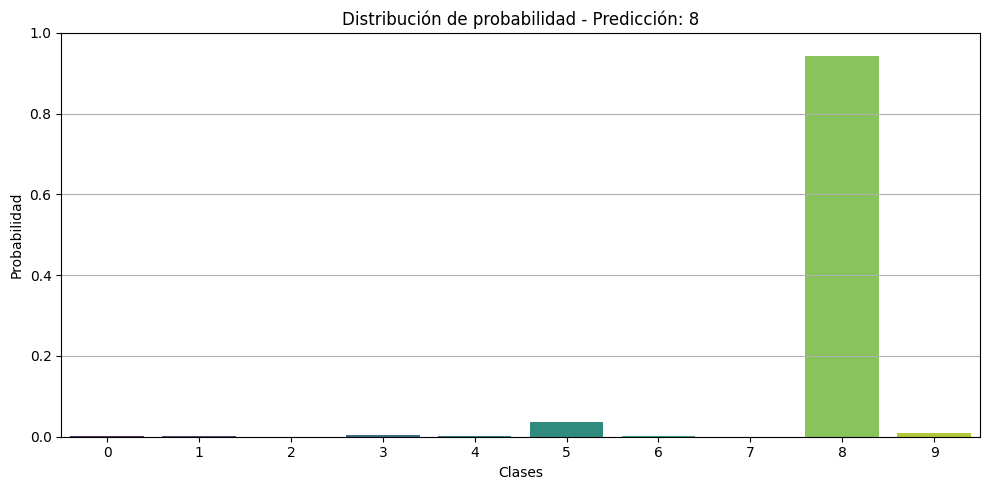

'8'

In [ ]:
predict_letter('/content/test/noise/8.png')

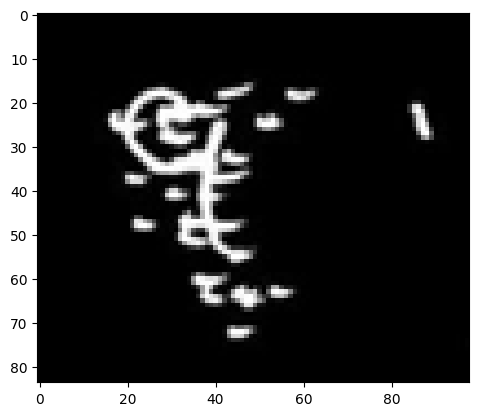

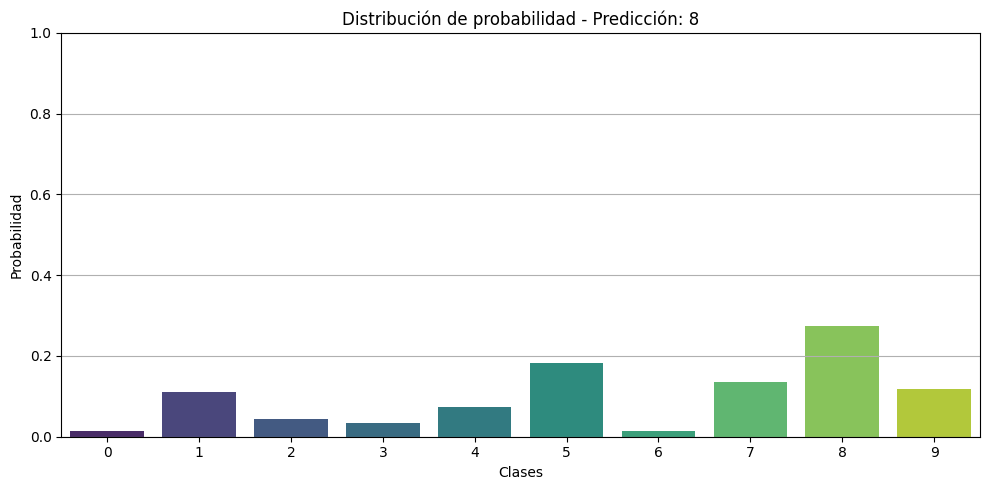

'8'

In [ ]:
predict_letter('/content/test/noise/9.png')

#Conclusi√≥n Ruido

El ruido visual tuvo un impacto considerable en la precisi√≥n del modelo. Esto se debe principalmente a que el ruido agregado suele superponerse directamente sobre los d√≠gitos, ocultando caracter√≠sticas clave como curvas, bordes o trazos distintivos. En algunos casos, el ruido act√∫a como una mancha que distorsiona la forma del n√∫mero, dificultando su interpretaci√≥n. Como resultado, el modelo genera distribuciones de probabilidad muy disputadas, donde no hay una clase claramente dominante, lo que refleja la incertidumbre del modelo ante este tipo de interferencia.

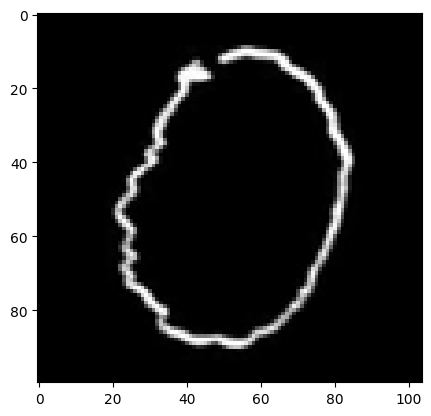

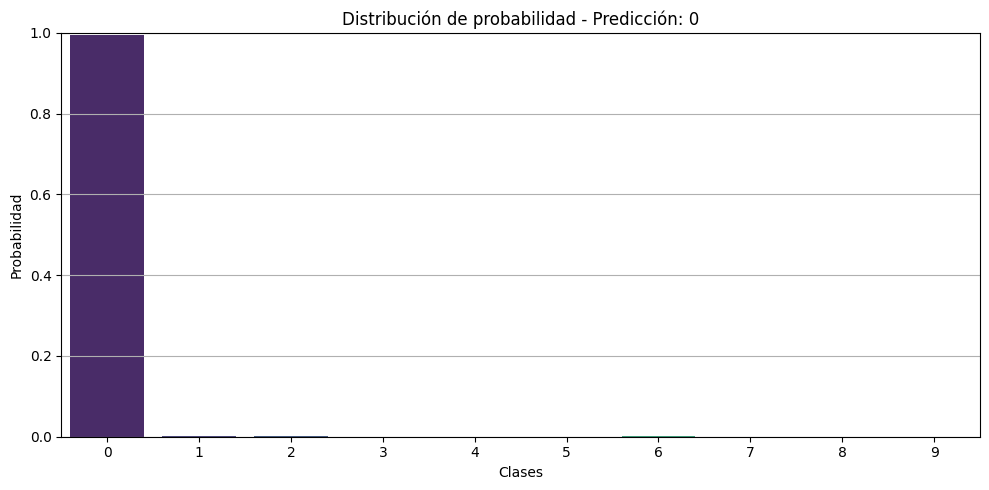

'0'

In [ ]:
predict_letter('/content/test/special/0.png')

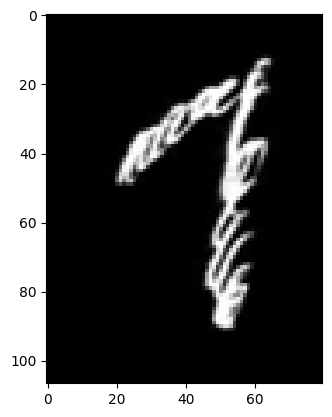

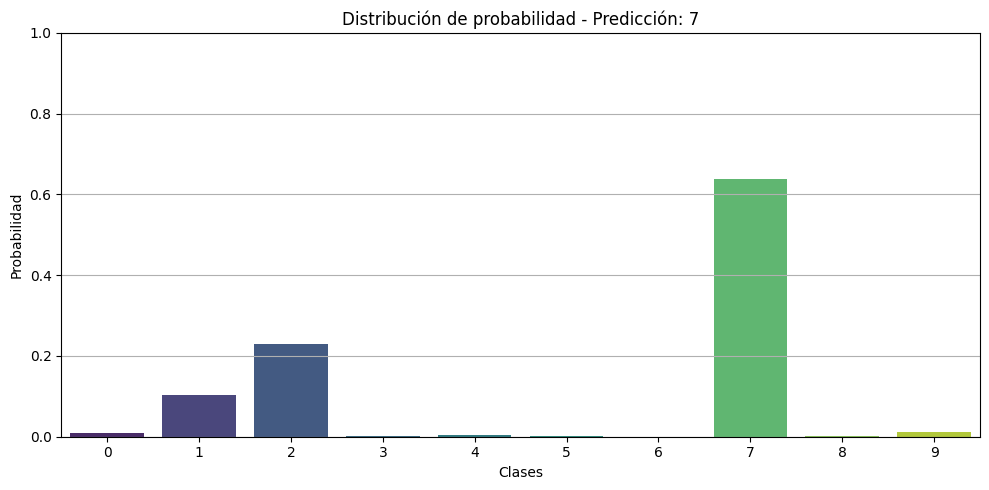

'7'

In [ ]:
predict_letter('/content/test/special/1.png')

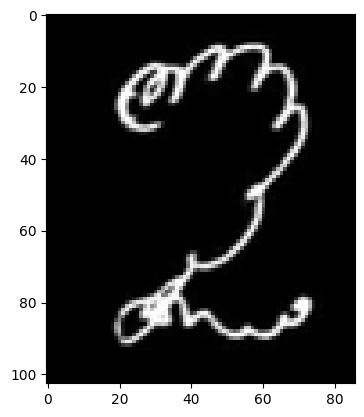

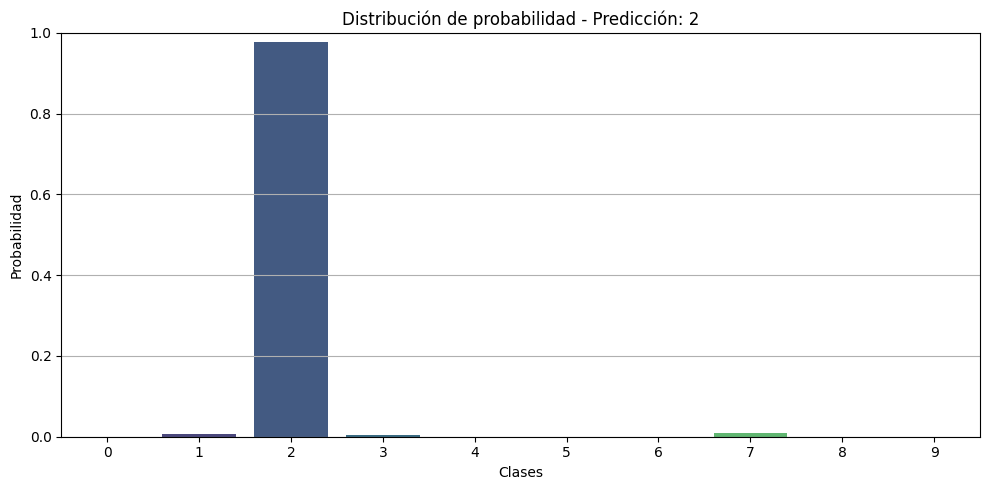

'2'

In [ ]:
predict_letter('/content/test/special/2.png')

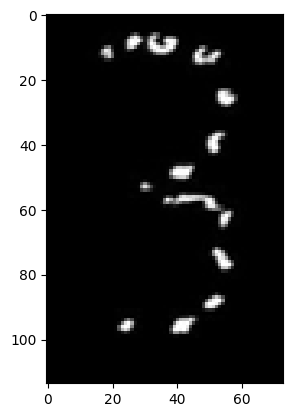

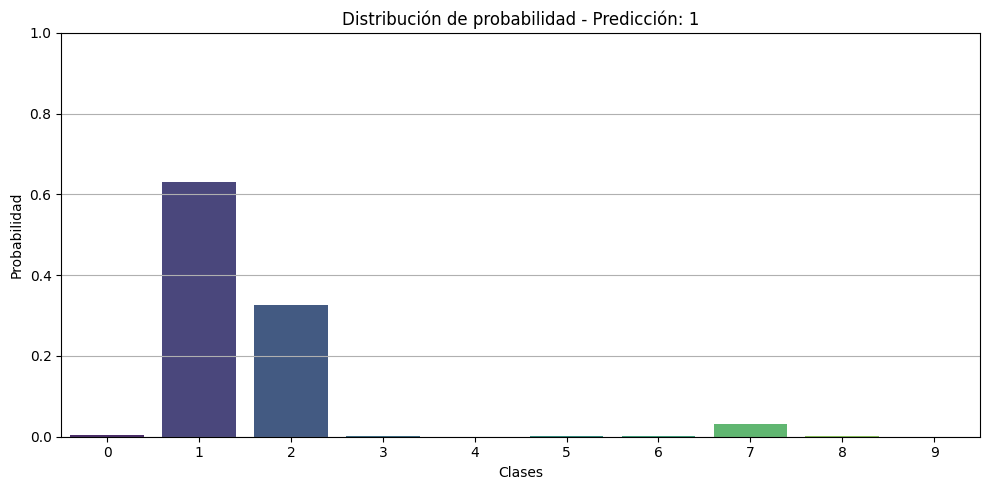

'1'

In [ ]:
predict_letter('/content/test/special/3.png')

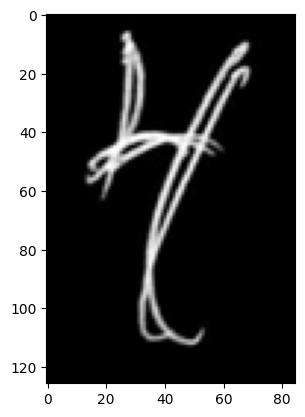

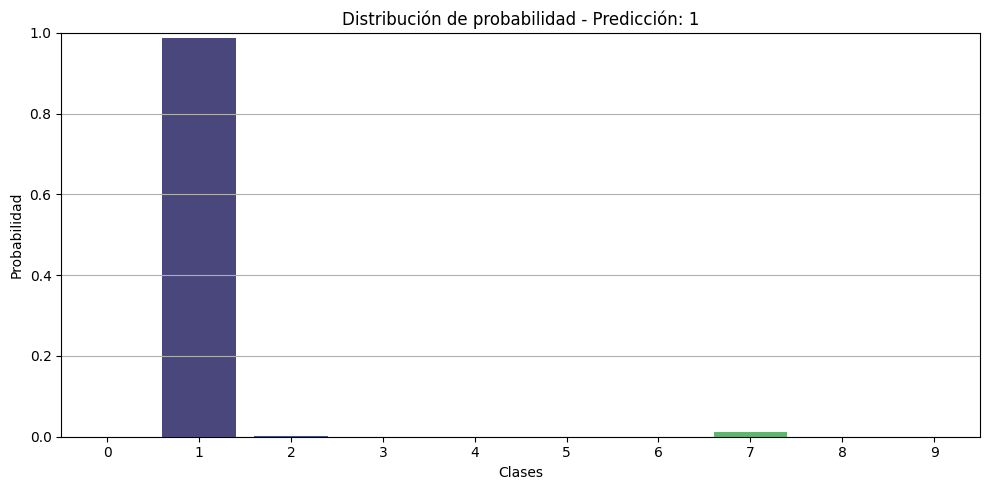

'1'

In [ ]:
predict_letter('/content/test/special/4.png')

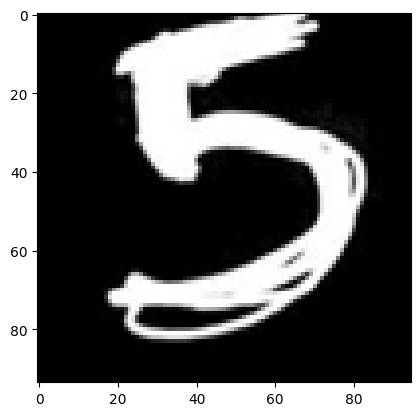

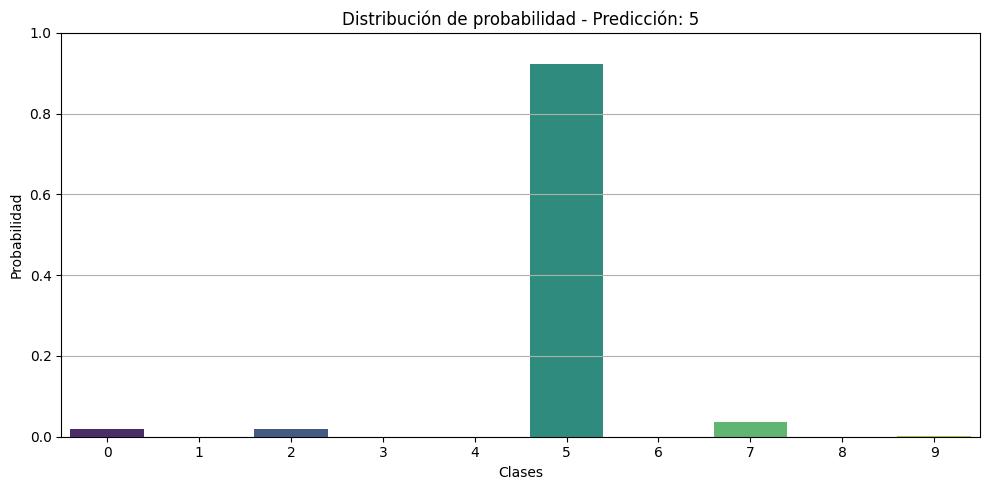

'5'

In [ ]:
predict_letter('/content/test/special/5.png')

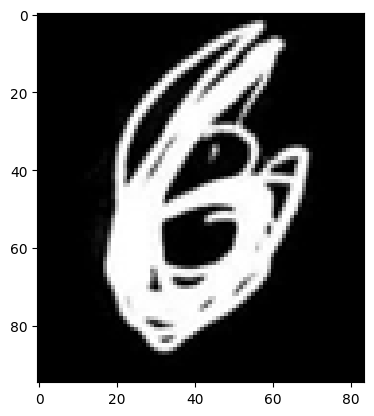

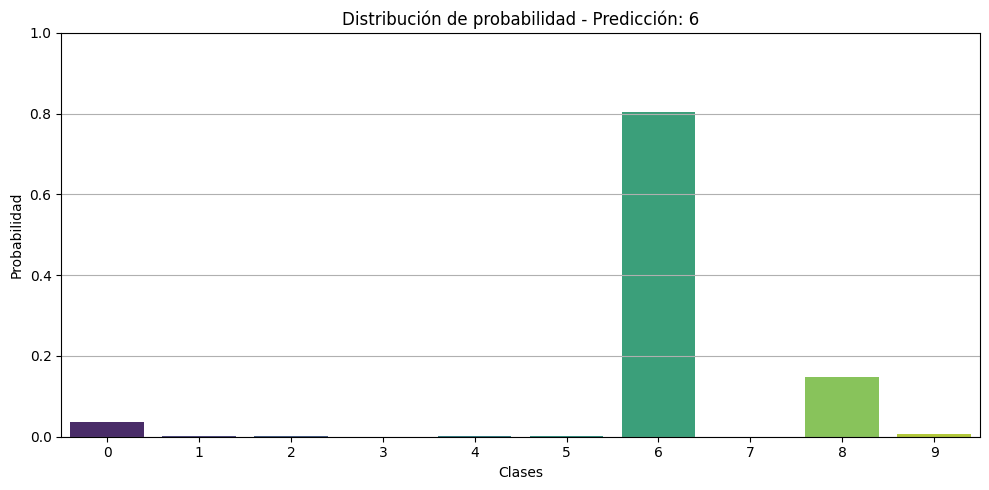

'6'

In [ ]:
predict_letter('/content/test/special/6.png')

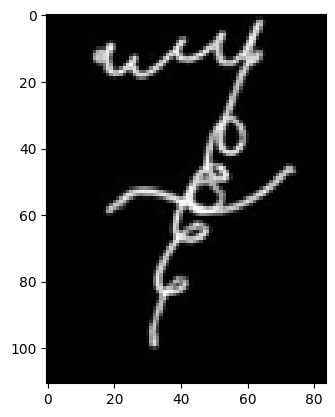

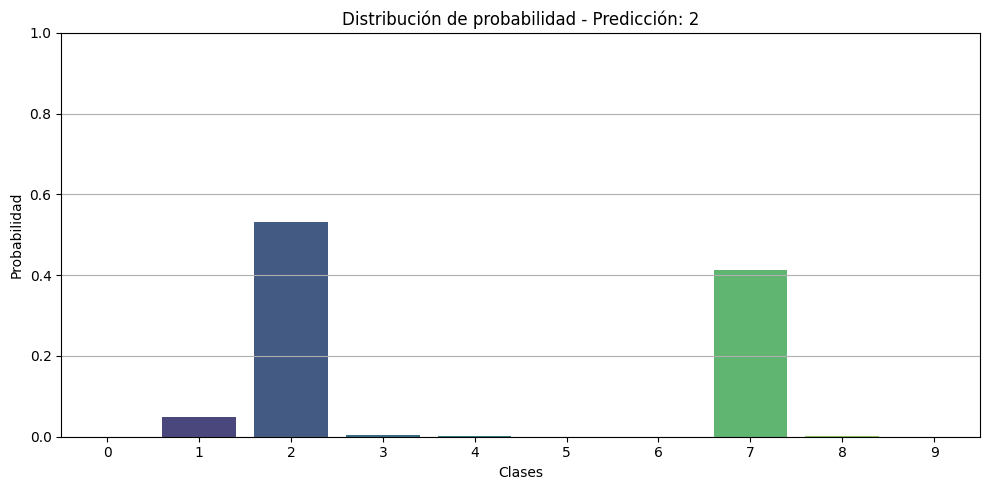

'2'

In [ ]:
predict_letter('/content/test/special/7.png')

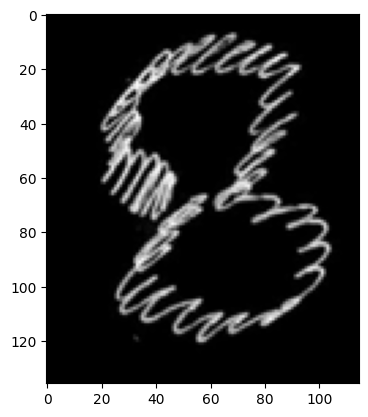

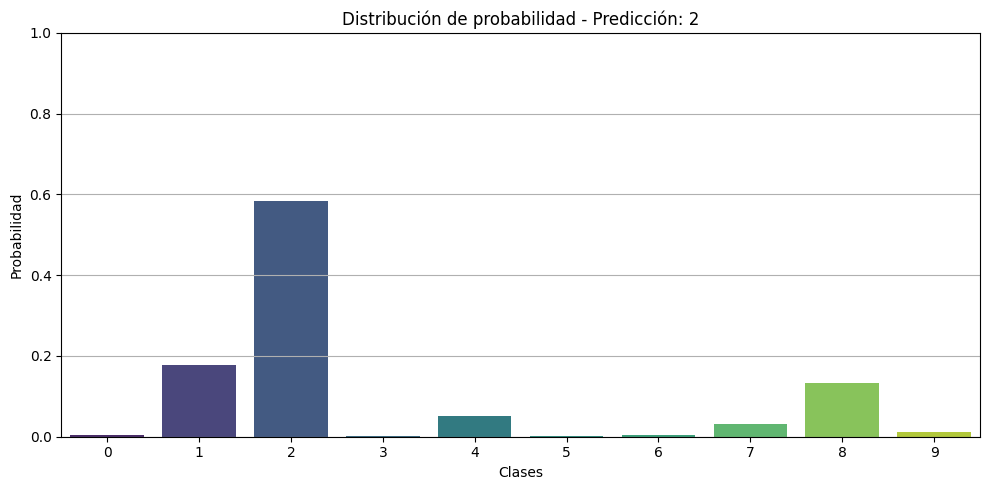

'2'

In [ ]:
predict_letter('/content/test/special/8.png')

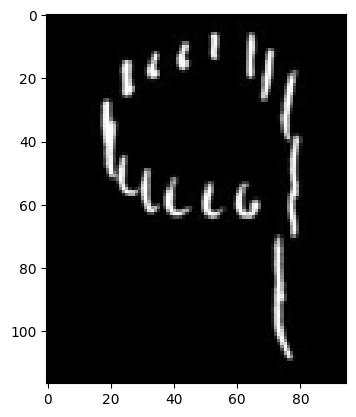

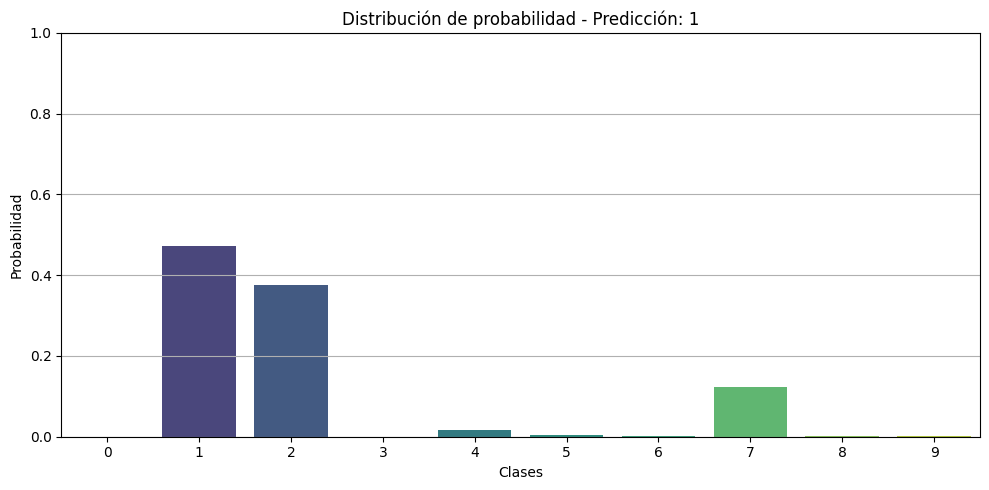

'1'

In [ ]:
predict_letter('/content/test/special/9.png')

##CONCLUSION ESPECIAL

Las im√°genes especiales, debido a sus formas poco convencionales o patrones de l√≠neas at√≠picos, afectan notablemente el desempe√±o del modelo. Aunque para un observador humano resulta relativamente sencillo identificar el d√≠gito, el modelo no logra reconocerlos correctamente, lo que indica que depende de patrones visuales espec√≠ficos aprendidos durante el entrenamiento y no generaliza bien ante estilos inusuales de escritura.

## 4b.5 Resumen
En resumen el ingreso de valores distintos a lo cotidiano, si afecta la precisi√≥n del modelo, lo cual sirve para poder medir el nivel de efectividad realista, quitando el perfeccionismo.
Y se debe realizar ajustes al modelo quias y asignar mas datos realistas para que el modelo pueda tomar en cuenta esos casos

# Preguntas

1. ¬øPor qu√© es importante que las im√°genes utilizadas para hacer predicciones tengan el mismo formato (dimensiones y color) que las im√°genes con las que se entren√≥ el modelo?

  Es importante porque el modelo fue entrenado espec√≠ficamente con im√°genes de un solo canal (escala de grises) y con una resoluci√≥n de 28x28 p√≠xeles. Estas caracter√≠sticas definen la estructura de entrada del modelo.

2. Describe los pasos necesarios para procesar una imagen antes de hacer una predicci√≥n con el modelo entrenado. ¬øQu√© transformaciones se deben aplicar?

  Los pasos para procesar la imagen son:
  Resize : volver la imagen de tama√±o m x n en una matriz de 28 x 28 en estos casos
  Greyscale : Poner la imagen en escala de grises ya que el modelo fue entrenado con imagenes de un solo canal y escala de grises es ese canal.
  Normalizar: normalizar los valores de 0 a 255 en 0 a 1.
  Batch: Se agrega dimensi√≥n adicional para simular que se trabaja con lotes de imagenes.

3. ¬øQu√© es la "dimensi√≥n del lote" (batch) y por qu√© es necesario agregarla cuando hacemos predicciones con el modelo?

  La dimensi√≥n del lote es una dimensi√≥n adicional que se utiliza para representar un grupo de im√°genes que se procesan simult√°neamente. Durante el entrenamiento, se utilizan lotes de im√°genes para mejorar la eficiencia computacional.

4. ¬øC√≥mo interpreta el modelo las predicciones que genera? Explica el formato de salida y c√≥mo se convierte en un n√∫mero.

  El modelo genera como salida un vector con 10 valores, cada uno representando la probabilidad de que la imagen corresponda a un d√≠gito del 0 al 9. Estos valores se obtienen mediante la √∫ltima capa del modelo, que generalmente es una capa totalmente conectada seguida de una funci√≥n softmax. El valor m√°s alto del vector indica la clase m√°s probable.